In [2]:
import pickle
import numpy as np
from pathlib import Path

np.set_printoptions(precision=5, suppress=True)

DATA_DIR = Path("Cleaned_US_data")

def load_split(filename: str):
    """Load one split and print a compact summary ."""
    path = DATA_DIR / filename
    with open(path, "rb") as f:
        data = pickle.load(f)

    print(f"\n=== {filename} ===")
    print("Type:", type(data))
    print("Num trajectories (vessels):", len(data))
    if len(data) > 0:
        s = data[0]
        traj = np.asarray(s["traj"])
        print("Sample keys:", list(s.keys()))
        print("MMSI:", s.get("mmsi"))
        print("traj shape:", traj.shape)
        print("traj dtype:", traj.dtype)
        print("first row:", traj[0])
    return data

# Load splits
train_data = load_split("us_continent_2024_train_track.pkl")
valid_data = load_split("us_continent_2024_valid_track.pkl")
test_data  = load_split("us_continent_2024_test_track.pkl")

# Optional: quick totals
total_msgs_train = sum(np.asarray(v["traj"]).shape[0] for v in train_data)
total_msgs_valid = sum(np.asarray(v["traj"]).shape[0] for v in valid_data)
total_msgs_test  = sum(np.asarray(v["traj"]).shape[0] for v in test_data)
print(f"\nTotals — train: {total_msgs_train:,}  valid: {total_msgs_valid:,}  test: {total_msgs_test:,}")


=== us_continent_2024_train_track.pkl ===
Type: <class 'list'>
Num trajectories (vessels): 124298
Sample keys: ['mmsi', 'traj']
MMSI: 538007560
traj shape: (144, 11)
traj dtype: float64
first row: [2.12772e-01 7.02774e-01 3.06667e-01 1.20000e-01 4.70000e+01 1.70481e+09
 5.38008e+08 7.00000e+01 1.75000e+02 2.80000e+01 7.00000e+01]

=== us_continent_2024_valid_track.pkl ===
Type: <class 'list'>
Num trajectories (vessels): 5472
Sample keys: ['mmsi', 'traj']
MMSI: 319266100
traj shape: (103, 11)
traj dtype: float64
first row: [1.26410e-01 8.03582e-01 3.50000e-01 9.73333e-01 3.36000e+02 1.70869e+09
 3.19266e+08 3.70000e+01 3.50000e+01 7.00000e+00 3.70000e+01]

=== us_continent_2024_test_track.pkl ===
Type: <class 'list'>
Num trajectories (vessels): 13828
Sample keys: ['mmsi', 'traj']
MMSI: 368062150
traj shape: (46, 11)
traj dtype: float64
first row: [2.34621e-01 6.51124e-01 0.00000e+00 8.01111e-01 5.11000e+02 1.70897e+09
 3.68062e+08 3.10000e+01 9.00000e+00 6.00000e+00 3.10000e+01]

Total

In [3]:

import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture

# Column indices in traj (normalized dataset)
LAT_IDX, LON_IDX, SOG_IDX, COG_IDX, HEAD_IDX, TIME_IDX, MMSI_IDX, TYPE_IDX, LEN_IDX, WID_IDX, CARGO_IDX = range(11)

# 7 feature names (all derived from NORMALIZED values)
FEATURE_COLS = [
    "mean_sog_30min",                      # mean normalized SOG in window
    "frac_stopped_30min",                  # fraction of pings with very low normalized SOG
    "frac_slow_30min",                     # fraction of pings with moderate normalized SOG
    "mean_abs_turnrate_norm_per_min_30min",
    "cog_spike_norm_30min",
    "mean_accel_norm_per_hr_30min",
    "max_abs_accel_norm_per_hr_30min",
]

# thresholds IN NORMALIZED UNITS (0..1)
STOP_THRESH_NORM = 0.02   # SOG_norm < 0.02 => "stopped"
SLOW_THRESH_NORM = 0.25   # SOG_norm < 0.25 => "slow"


In [4]:
def wrap_angle_unit(delta: np.ndarray) -> np.ndarray:
    """
    Wrap differences of normalized heading/COG (0..1) into [-0.5, 0.5],
    i.e., at most half a revolution in either direction.
    """
    return (delta + 0.5) % 1.0 - 0.5


In [5]:
def compute_window_features_from_traj_norm(traj_window: np.ndarray) -> dict:
    """
    traj_window: (W, 11) slice from a single normalized traj.
    Returns the 7 behaviour features for this 30-min window.
    """
    # --- speed features (normalized sog in [0,1]) ---
    sog_norm = traj_window[:, SOG_IDX]

    mean_sog = float(sog_norm.mean())
    frac_stopped = float((sog_norm < STOP_THRESH_NORM).mean())
    frac_slow = float((sog_norm < SLOW_THRESH_NORM).mean())

    # --- turning features using normalized COG (0..1, circular) ---
    cog_norm = traj_window[:, COG_IDX]
    if cog_norm.size > 1:
        d_cog = np.diff(cog_norm)
        d_cog = wrap_angle_unit(d_cog)          # in "revolutions"
        dt_min = 10.0                           # 10-minute spacing between rows
        turnrate = np.abs(d_cog) / dt_min       # revolutions per minute

        mean_abs_turnrate = float(turnrate.mean())
        cog_spike = float(np.max(np.abs(d_cog)))  # biggest normalized jump
    else:
        mean_abs_turnrate = 0.0
        cog_spike = 0.0

    # --- acceleration features from normalized SOG ---
    if sog_norm.size > 1:
        dt_hr = 10.0 / 60.0                     # hours
        accel = np.diff(sog_norm) / dt_hr       # norm units per hour
        mean_accel = float(accel.mean())
        max_abs_accel = float(np.max(np.abs(accel)))
    else:
        mean_accel = 0.0
        max_abs_accel = 0.0

    return {
        "mean_sog_30min": mean_sog,
        "frac_stopped_30min": frac_stopped,
        "frac_slow_30min": frac_slow,
        "mean_abs_turnrate_norm_per_min_30min": mean_abs_turnrate,
        "cog_spike_norm_30min": cog_spike,
        "mean_accel_norm_per_hr_30min": mean_accel,
        "max_abs_accel_norm_per_hr_30min": max_abs_accel,
    }


In [6]:
def build_cargo_windows_from_normalized_split(split_data, window_len_rows: int = 3) -> pd.DataFrame:
    """
    split_data: list of dicts, each with 'mmsi' and 'traj' (normalized).
    Returns DataFrame of windows for cargo vessels only (type 70-79).
    """
    rows = []

    for vessel in tqdm(split_data, desc="Building cargo windows"):
        traj = vessel["traj"]           # (T, 11)
        if traj.shape[0] < window_len_rows:
            continue

        # Sort by timestamp just in case
        order = np.argsort(traj[:, TIME_IDX])
        traj_sorted = traj[order]

        # We assume vessel_type is constant across traj
        vessel_type = int(traj_sorted[0, TYPE_IDX])
        if not (70 <= vessel_type <= 79):
            continue  # skip non-cargo

        mmsi = int(traj_sorted[0, MMSI_IDX])

        T = traj_sorted.shape[0]
        for start_idx in range(0, T - window_len_rows + 1, window_len_rows):
            w = traj_sorted[start_idx:start_idx + window_len_rows, :]

            # centre position in normalized space (0..1)
            lat_center = float(w[:, LAT_IDX].mean())
            lon_center = float(w[:, LON_IDX].mean())

            start_time = pd.to_datetime(w[0, TIME_IDX], unit="s")

            feat = compute_window_features_from_traj_norm(w)

            row = {
                "mmsi": mmsi,
                "vessel_type": vessel_type,
                "start_time": start_time,
                "lat_center_norm": lat_center,
                "lon_center_norm": lon_center,
            }
            row.update(feat)
            rows.append(row)

    return pd.DataFrame(rows)

# Build windows for cargo vessels in TRAIN split
cargo_windows_df = build_cargo_windows_from_normalized_split(train_data, window_len_rows=3)
cargo_windows_df.head()
print("Num cargo windows:", len(cargo_windows_df))


Building cargo windows: 100%|██████████| 124298/124298 [03:53<00:00, 532.81it/s] 


Num cargo windows: 844995


In [7]:
cargo_windows_df

mmsi  vessel_type          start_time  lat_center_norm  \
0       538007560           70 2024-01-09 13:08:22         0.213278   
1       538007560           70 2024-01-09 13:38:22         0.214782   
2       538007560           70 2024-01-09 14:08:22         0.215992   
3       538007560           70 2024-01-09 14:38:22         0.217250   
4       538007560           70 2024-01-09 15:08:22         0.217995   
...           ...          ...                 ...              ...   
844990  477594100           70 2024-01-31 08:07:26         0.661781   
844991  477594100           70 2024-01-31 08:37:26         0.662787   
844992  477594100           70 2024-01-31 09:07:26         0.663763   
844993  477594100           70 2024-01-31 09:37:26         0.664721   
844994  477594100           70 2024-01-31 10:07:26         0.665667   

        lon_center_norm  mean_sog_30min  frac_stopped_30min  frac_slow_30min  \
0              0.702955        0.308888                 0.0         0.000000   
1              0.703477        0.283858                 0.0         0.333333   
2              0.703914        0.238467                 0.0         0.666667   
3              0.704403        0.236151                 0.0         0.666667   
4              0.704721        0.103955                 0.0         1.000000   
...                 ...             ...                 ...              ...   
844990         0.350870        0.348109                 0.0         0.000000   
844991         0.349767        0.341685                 0.0         0.000000   
844992         0.348658        0.347050                 0.0         0.000000   
844993         0.347548        0.337589                 0.0         0.000000   
844994         0.346451        0.338167                 0.0         0.000000   

        mean_abs_turnrate_norm_per_min_30min  cog_spike_norm_30min  \
0                                   0.000428              0.008240   
1                                   0.000580              0.009661   
2                                   0.001162              0.017071   
3                                   0.000165              0.003026   
4                                   0.000905              0.015240   
...                                      ...                   ...   
844990                              0.000863              0.013131   
844991                              0.001500              0.019022   
844992                              0.001069              0.015733   
844993                              0.000220              0.003583   
844994                              0.000479              0.005637   

        mean_accel_norm_per_hr_30min  max_abs_accel_norm_per_hr_30min  
0                          -0.002000                         0.047987  
1                          -0.146448                         0.470835  
2                           0.198551                         0.461793  
3                          -0.227500                         0.240714  
4                           0.044325                         0.154201  
...                              ...                              ...  
844990                     -0.026742                         0.040563  
844991                      0.009525                         0.054359  
844992                      0.013695                         0.107143  
844993                     -0.026703                         0.065000  
844994                     -0.074797                         0.111407  

[844995 rows x 12 columns]

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

# Your 7 behaviour features
FEATURE_COLS = [
    "mean_sog_30min",
    "frac_stopped_30min",
    "frac_slow_30min",
    "mean_abs_turnrate_norm_per_min_30min",
    "cog_spike_norm_30min",
    "mean_accel_norm_per_hr_30min",
    "max_abs_accel_norm_per_hr_30min",
]

In [9]:
X = cargo_windows_df[FEATURE_COLS].to_numpy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Total windows:", X_scaled.shape[0])
print("Feature means after scaling (≈0):", X_scaled.mean(axis=0).round(3))
print("Feature stds after scaling (≈1):", X_scaled.std(axis=0).round(3))


Total windows: 844995
Feature means after scaling (≈0): [-0.  0. -0.  0. -0. -0. -0.]
Feature stds after scaling (≈1): [1. 1. 1. 1. 1. 1. 1.]


In [10]:
def gmm_metrics_for_sample(X_scaled, k_range, max_sample=100_000, seed=42):
    """
    For a given X_scaled, randomly subsample up to max_sample rows, then
    for each k in k_range fit a GMM and compute BIC, AIC, ICL, silhouette.
    Returns a DataFrame with one row per K.
    """
    N = X_scaled.shape[0]
    rng = np.random.RandomState(seed)

    if N > max_sample:
        idx = rng.choice(N, size=max_sample, replace=False)
        X_s = X_scaled[idx]
    else:
        X_s = X_scaled

    print(f"{N} windows in dataset. Subsample size = {X_s.shape[0]} (seed={seed})")

    metrics = []
    for k in k_range:
        gmm = GaussianMixture(
            n_components=k,
            covariance_type="full",
            random_state=seed,
        )
        gmm.fit(X_s)

        bic = gmm.bic(X_s)
        aic = gmm.aic(X_s)

        tau = gmm.predict_proba(X_s)
        eps = 1e-12
        icl = bic - 2.0 * (tau * np.log(tau + eps)).sum()

        labels = gmm.predict(X_s)
        sil = silhouette_score(X_s, labels)

        metrics.append({
            "k": k,
            "BIC": bic,
            "AIC": aic,
            "ICL": icl,
            "silhouette": sil,
        })

        print(
            f"K={k:2d}  "
            f"BIC={bic: .3e}  "
            f"AIC={aic: .3e}  "
            f"ICL={icl: .3e}  "
            f"silhouette={sil:.4f}"
        )

    return pd.DataFrame(metrics)

# ============================================================
# 3. Run 3 subsamples and collect metrics
# ============================================================
k_range = range(2, 12)  # K = 2..11
seeds = [0, 1, 2]

all_runs = []

for run_idx, seed in enumerate(seeds, start=1):
    print("\n" + "="*60)
    print(f"Running GMM metrics for subsample RUN {run_idx} (seed={seed})")
    print("="*60)

    df_run = gmm_metrics_for_sample(X_scaled, k_range, max_sample=100_000, seed=seed)
    df_run["run"] = run_idx
    all_runs.append(df_run)

    # Show summary of best K by each metric for this run
    best_bic_k = int(df_run.loc[df_run["BIC"].idxmin(), "k"])
    best_icl_k = int(df_run.loc[df_run["ICL"].idxmin(), "k"])
    best_sil_k = int(df_run.loc[df_run["silhouette"].idxmax(), "k"])

    print(f"\nSummary for run {run_idx}:")
    print(f"  Best K by BIC       : {best_bic_k}")
    print(f"  Best K by ICL       : {best_icl_k}")
    print(f"  Best K by Silhouette: {best_sil_k}")

# Combine all runs into one DataFrame for plotting
metrics_all = pd.concat(all_runs, ignore_index=True)


Running GMM metrics for subsample RUN 1 (seed=0)
844995 windows in dataset. Subsample size = 100000 (seed=0)
K= 2  BIC= 3.762e+05  AIC= 3.755e+05  ICL= 3.796e+05  silhouette=0.2023
K= 3  BIC=-1.251e+06  AIC=-1.252e+06  ICL=-1.250e+06  silhouette=0.4822
K= 4  BIC=-2.241e+06  AIC=-2.243e+06  ICL=-2.241e+06  silhouette=0.4126
K= 5  BIC=-2.097e+06  AIC=-2.099e+06  ICL=-2.093e+06  silhouette=0.3914
K= 6  BIC=-2.246e+06  AIC=-2.248e+06  ICL=-2.243e+06  silhouette=0.4004
K= 7  BIC=-2.760e+06  AIC=-2.762e+06  ICL=-2.756e+06  silhouette=0.4021
K= 8  BIC=-2.473e+06  AIC=-2.475e+06  ICL=-2.465e+06  silhouette=0.2767
K= 9  BIC=-2.956e+06  AIC=-2.959e+06  ICL=-2.950e+06  silhouette=0.2746
K=10  BIC=-2.970e+06  AIC=-2.974e+06  ICL=-2.963e+06  silhouette=0.2795
K=11  BIC=-3.031e+06  AIC=-3.035e+06  ICL=-3.019e+06  silhouette=0.1657

Summary for run 1:
  Best K by BIC       : 11
  Best K by ICL       : 11
  Best K by Silhouette: 3

Running GMM metrics for subsample RUN 2 (seed=1)
844995 windows in da

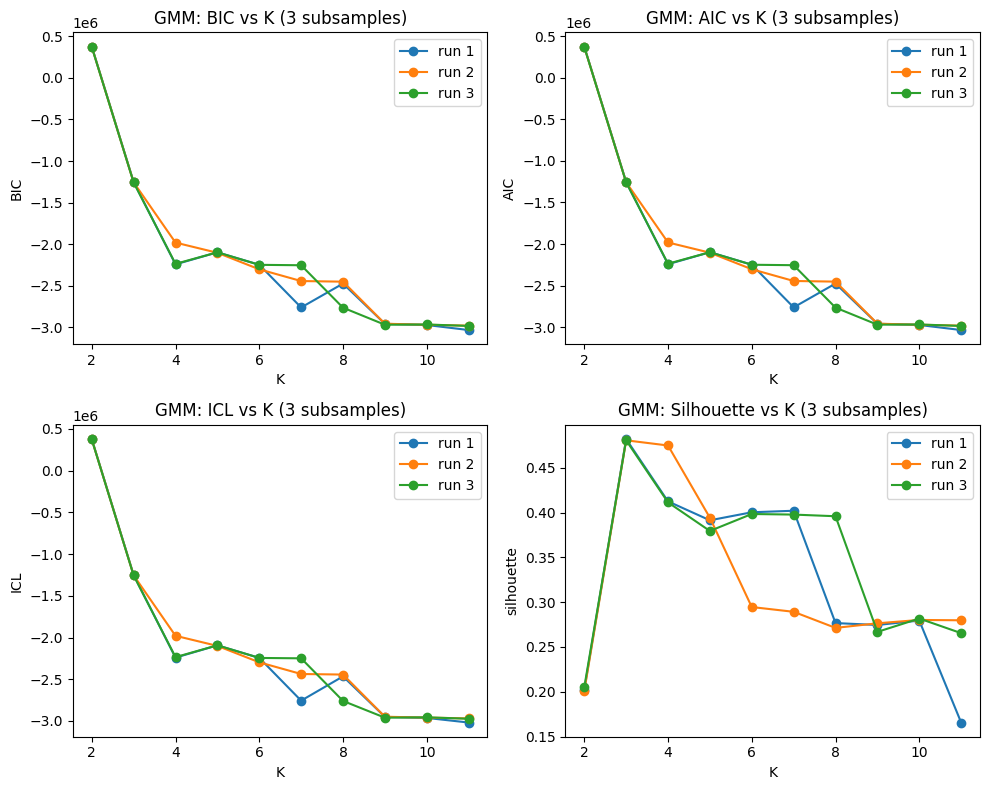

In [11]:
import matplotlib.pyplot as plt

# 4 subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

metric_names = ["BIC", "AIC", "ICL", "silhouette"]
titles = [
    "GMM: BIC vs K (3 subsamples)",
    "GMM: AIC vs K (3 subsamples)",
    "GMM: ICL vs K (3 subsamples)",
    "GMM: Silhouette vs K (3 subsamples)",
]

# metrics_all has one column "run" = 1,2,3
run_ids = sorted(metrics_all["run"].unique())

for ax, metric, title in zip(axes.ravel(), metric_names, titles):
    for run_id in run_ids:
        df_run = metrics_all[metrics_all["run"] == run_id]
        ax.plot(df_run["k"], df_run[metric],
                marker="o", label=f"run {run_id}")
    ax.set_xlabel("K")
    ax.set_ylabel(metric)
    ax.set_title(title)
    ax.legend()

plt.tight_layout()
plt.show()


In [12]:
cargo_windows_df      
FEATURE_COLS = [
    "mean_sog_30min",
    "frac_stopped_30min",
    "frac_slow_30min",
    "mean_abs_turnrate_norm_per_min_30min",
    "cog_spike_norm_30min",
    "mean_accel_norm_per_hr_30min",
    "max_abs_accel_norm_per_hr_30min",
]


In [13]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

# ---- build feature matrix and scale (in case not already done) ----
X = cargo_windows_df[FEATURE_COLS].to_numpy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Total windows:", X_scaled.shape[0])

# ---- final GMM with K = 7 on FULL data ----
K_FINAL = 7

gmm_k7 = GaussianMixture(
    n_components=K_FINAL,
    covariance_type="full",
    random_state=42,
    max_iter=100,
)
gmm_k7.fit(X_scaled)

# labels + probabilities for all windows
labels_k7 = gmm_k7.predict(X_scaled)
probs_k7  = gmm_k7.predict_proba(X_scaled)

max_prob   = probs_k7.max(axis=1)
second_prob = np.partition(probs_k7, -2, axis=1)[:, -2]
margin     = max_prob - second_prob

cargo_windows_df["gmm_k7_cluster"]   = labels_k7
cargo_windows_df["gmm_k7_max_prob"]  = max_prob
cargo_windows_df["gmm_k7_margin"]    = margin

print("Cluster counts (K=7):")
print(pd.Series(labels_k7).value_counts().sort_index())


Total windows: 844995
Cluster counts (K=7):
0    361165
1    217744
2     37279
3      6520
4     15177
5     61962
6    145148
Name: count, dtype: int64


In [14]:
gmm_k7

GaussianMixture(n_components=7, random_state=42)

In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

# -------- 1. Features and scaling --------
FEATURE_COLS = [
    "mean_sog_30min",
    "frac_stopped_30min",
    "frac_slow_30min",
    "mean_abs_turnrate_norm_per_min_30min",
    "cog_spike_norm_30min",
    "mean_accel_norm_per_hr_30min",
    "max_abs_accel_norm_per_hr_30min",
]

X = cargo_windows_df[FEATURE_COLS].to_numpy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Total windows:", X_scaled.shape[0])

# -------- 2. Final GMM with K=7 --------
K_FINAL = 7

gmm7 = GaussianMixture(
    n_components=K_FINAL,
    covariance_type="full",
    random_state=42,
    max_iter=100,
)
gmm7.fit(X_scaled)

# Hard labels + probabilities
labels7 = gmm7.predict(X_scaled)
probs7  = gmm7.predict_proba(X_scaled)

max_prob   = probs7.max(axis=1)
second_prob = np.partition(probs7, -2, axis=1)[:, -2]
margin     = max_prob - second_prob

cargo_windows_df["gmm_k7_cluster"]  = labels7
cargo_windows_df["gmm_k7_max_prob"] = max_prob
cargo_windows_df["gmm_k7_margin"]   = margin

print("Cluster counts (K=7):")
print(pd.Series(labels7).value_counts().sort_index())


Total windows: 844995
Cluster counts (K=7):
0    361165
1    217744
2     37279
3      6520
4     15177
5     61962
6    145148
Name: count, dtype: int64


In [16]:
# Empirical centroids in ORIGINAL feature units
centroids_k7 = (
    cargo_windows_df
    .groupby("gmm_k7_cluster")[FEATURE_COLS]
    .mean()
    .sort_index()
)

counts_k7 = (
    cargo_windows_df["gmm_k7_cluster"]
    .value_counts()
    .sort_index()
)

centroids_with_counts = centroids_k7.copy()
centroids_with_counts["count"] = counts_k7

print("GMM K=7 centroids (original feature means):")
display(centroids_with_counts)


GMM K=7 centroids (original feature means):


mean_sog_30min  frac_stopped_30min  frac_slow_30min  \
gmm_k7_cluster                                                        
0                     0.421811            0.000000         0.000000   
1                     0.000458            1.000000         1.000000   
2                     0.011963            0.819738         1.000000   
3                     0.273134            0.139008         0.386196   
4                     0.080294            0.415607         0.939053   
5                     0.129617            0.000000         1.000000   
6                     0.328976            0.000000         0.253181   

                mean_abs_turnrate_norm_per_min_30min  cog_spike_norm_30min  \
gmm_k7_cluster                                                               
0                                           0.000464              0.006957   
1                                           0.006667              0.095755   
2                                           0.018085              0.247129   
3                                           0.024175              0.303013   
4                                           0.020046              0.282237   
5                                           0.001567              0.022029   
6                                           0.006995              0.109178   

                mean_accel_norm_per_hr_30min  max_abs_accel_norm_per_hr_30min  \
gmm_k7_cluster                                                                  
0                                   0.000510                         0.042595   
1                                  -0.000029                         0.003345   
2                                  -0.006293                         0.066871   
3                                   0.615386                         1.133963   
4                                  -0.110716                         0.808339   
5                                  -0.002339                         0.066856   
6                                  -0.017510                         0.360038   

                 count  
gmm_k7_cluster          
0               361165  
1               217744  
2                37279  
3                 6520  
4                15177  
5                61962  
6               145148

In [17]:
centers_model_orig = pd.DataFrame(
    scaler.inverse_transform(gmm7.means_),
    columns=FEATURE_COLS,
)
centers_model_orig["count"] = counts_k7.values
print("GMM K=7 model means (inverse-transformed):")
display(centers_model_orig)


GMM K=7 model means (inverse-transformed):


mean_sog_30min  frac_stopped_30min  frac_slow_30min  \
0        0.421801        7.993606e-15     1.060263e-14   
1        0.000455        1.000000e+00     1.000000e+00   
2        0.011859        8.226927e-01     1.000000e+00   
3        0.268951        1.383882e-01     4.024484e-01   
4        0.079964        4.173383e-01     9.379328e-01   
5        0.129630       -9.436896e-16     1.000000e+00   
6        0.328588       -3.552714e-15     2.543429e-01   

   mean_abs_turnrate_norm_per_min_30min  cog_spike_norm_30min  \
0                              0.000467              0.007016   
1                              0.006646              0.095502   
2                              0.018133              0.247551   
3                              0.024163              0.302873   
4                              0.019920              0.281294   
5                              0.001565              0.022003   
6                              0.007007              0.109332   

   mean_accel_norm_per_hr_30min  max_abs_accel_norm_per_hr_30min   count  
0                      0.000510                         0.042651  361165  
1                     -0.000029                         0.003334  217744  
2                     -0.006206                         0.066234   37279  
3                      0.609026                         1.120740    6520  
4                     -0.115928                         0.807573   15177  
5                     -0.002335                         0.066817   61962  
6                     -0.017700                         0.360352  145148

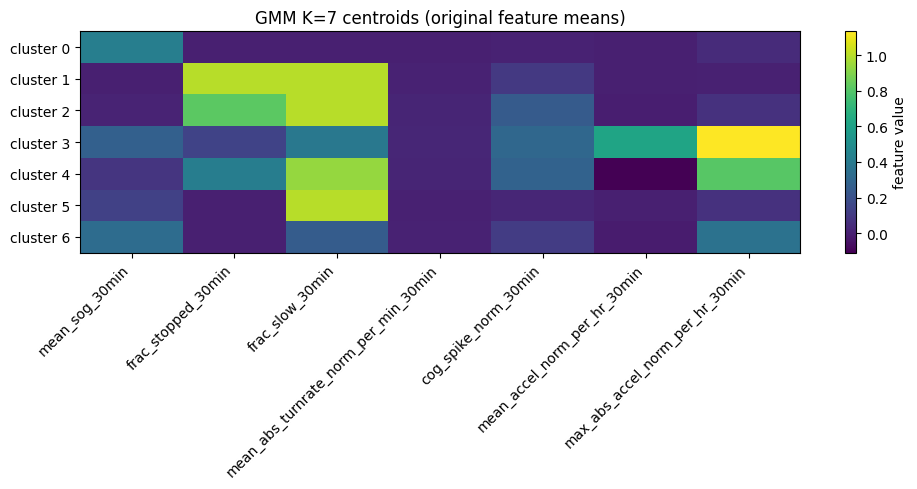

In [18]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 5))

im = ax.imshow(centroids_k7.values, aspect="auto")

ax.set_xticks(np.arange(len(FEATURE_COLS)))
ax.set_xticklabels(FEATURE_COLS, rotation=45, ha="right")

ax.set_yticks(np.arange(K_FINAL))
ax.set_yticklabels([f"cluster {k}" for k in range(K_FINAL)])

ax.set_title("GMM K=7 centroids (original feature means)")
fig.colorbar(im, ax=ax, label="feature value")

plt.tight_layout()
plt.show()


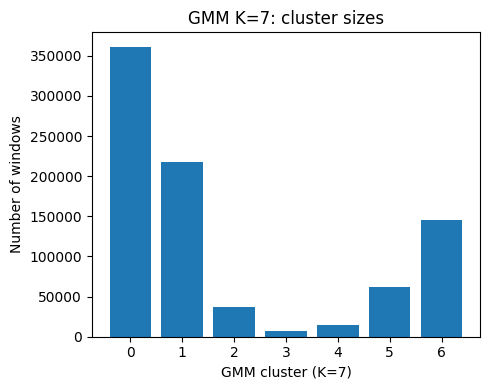

In [19]:
fig, ax = plt.subplots(figsize=(5, 4))
ax.bar(np.arange(K_FINAL), counts_k7.values)
ax.set_xticks(np.arange(K_FINAL))
ax.set_xticklabels([str(k) for k in range(K_FINAL)])
ax.set_xlabel("GMM cluster (K=7)")
ax.set_ylabel("Number of windows")
ax.set_title("GMM K=7: cluster sizes")
plt.tight_layout()
plt.show()


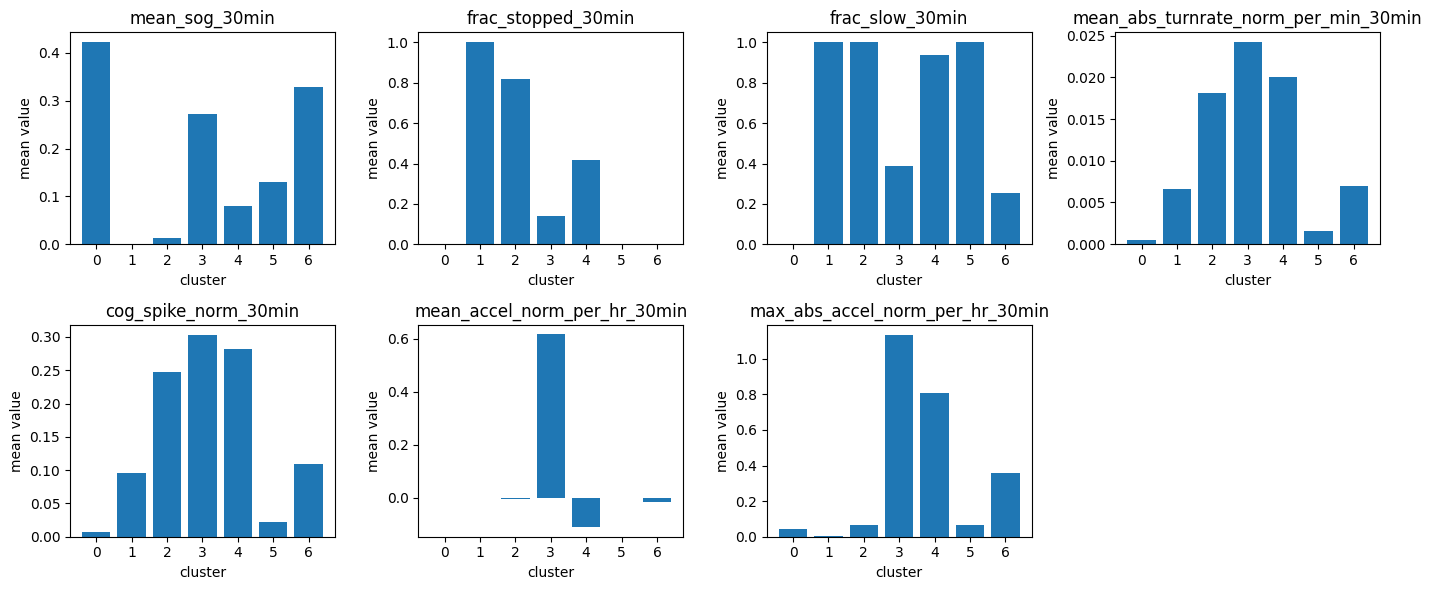

In [20]:
fig, axes = plt.subplots(2, 4, figsize=(14, 6))
axes = axes.ravel()

for i, feat in enumerate(FEATURE_COLS):
    ax = axes[i]
    ax.bar(np.arange(K_FINAL), centroids_k7[feat].values)
    ax.set_xticks(np.arange(K_FINAL))
    ax.set_xticklabels([str(k) for k in range(K_FINAL)])
    ax.set_title(feat)
    ax.set_xlabel("cluster")
    ax.set_ylabel("mean value")

# Hide any unused subplot (since 7 features but 8 axes)
for j in range(len(FEATURE_COLS), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)
from sklearn.metrics import pairwise_distances_argmin

# --- your 7 behaviour features ---
FEATURE_COLS = [
    "mean_sog_30min",
    "frac_stopped_30min",
    "frac_slow_30min",
    "mean_abs_turnrate_norm_per_min_30min",
    "cog_spike_norm_30min",
    "mean_accel_norm_per_hr_30min",
    "max_abs_accel_norm_per_hr_30min",
]

X = cargo_windows_df[FEATURE_COLS].to_numpy()

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

N = X_scaled.shape[0]
print("Total windows:", N)


Total windows: 844995


In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)

# X_scaled should already exist (StandardScaler on the 7 features)
# If not, rebuild it with your FEATURE_COLS and scaler like before.

def hc_metrics_for_sample(X_scaled, k_range, max_sample=50_000, seed=42):
    """
    Subsample up to max_sample points from X_scaled, then for each K in k_range:
      - fit AgglomerativeClustering (Ward linkage)
      - compute silhouette, CHI, DBI
    Return a DataFrame of metrics.
    """
    N = X_scaled.shape[0]
    rng = np.random.RandomState(seed)

    # --- subsample ---
    if N > max_sample:
        idx = rng.choice(N, size=max_sample, replace=False)
    else:
        idx = np.arange(N)
    X_s = X_scaled[idx]

    print(f"{N} windows in dataset. Subsample size = {X_s.shape[0]} (seed={seed})")

    rows = []
    for k in k_range:
        print(f"Fitting HC for K={k} ...")
        hc = AgglomerativeClustering(
            n_clusters=k,
            linkage="ward",          # Euclidean + Ward is standard for numeric features
            # compute_full_tree="auto"  # default
        )

        labels = hc.fit_predict(X_s)

        sil = silhouette_score(X_s, labels)
        chi = calinski_harabasz_score(X_s, labels)
        dbi = davies_bouldin_score(X_s, labels)

        rows.append({
            "k": k,
            "silhouette": sil,
            "CHI": chi,
            "DBI": dbi,
        })

        print(
            f"  K={k:2d}  "
            f"silhouette={sil:.4f}  "
            f"CHI={chi: .3e}  "
            f"DBI={dbi:.4f}"
        )

    return pd.DataFrame(rows)


In [23]:
k_range = range(2, 12)  # K = 2..11
hc_250k_df = hc_metrics_for_sample(X_scaled, k_range, max_sample=50_000, seed=42)

print("\nHC metrics on 250k subsample:")
display(hc_250k_df)

best_sil_k = int(hc_250k_df.loc[hc_250k_df["silhouette"].idxmax(), "k"])
best_chi_k = int(hc_250k_df.loc[hc_250k_df["CHI"].idxmax(), "k"])
best_dbi_k = int(hc_250k_df.loc[hc_250k_df["DBI"].idxmin(), "k"])

print("\nBest K by Silhouette:", best_sil_k)
print("Best K by Calinski–Harabasz:", best_chi_k)
print("Best K by Davies–Bouldin:", best_dbi_k)


844995 windows in dataset. Subsample size = 50000 (seed=42)
Fitting HC for K=2 ...
  K= 2  silhouette=0.4771  CHI= 2.649e+04  DBI=1.0320
Fitting HC for K=3 ...
  K= 3  silhouette=0.5193  CHI= 2.546e+04  DBI=1.2500
Fitting HC for K=4 ...
  K= 4  silhouette=0.5543  CHI= 2.653e+04  DBI=1.3654
Fitting HC for K=5 ...
  K= 5  silhouette=0.5723  CHI= 3.089e+04  DBI=0.8541
Fitting HC for K=6 ...
  K= 6  silhouette=0.5723  CHI= 3.057e+04  DBI=0.7867
Fitting HC for K=7 ...
  K= 7  silhouette=0.5715  CHI= 2.991e+04  DBI=0.9404
Fitting HC for K=8 ...
  K= 8  silhouette=0.5885  CHI= 2.949e+04  DBI=0.9481
Fitting HC for K=9 ...
  K= 9  silhouette=0.5883  CHI= 2.874e+04  DBI=0.9862
Fitting HC for K=10 ...
  K=10  silhouette=0.5877  CHI= 2.788e+04  DBI=1.0751
Fitting HC for K=11 ...
  K=11  silhouette=0.4208  CHI= 2.734e+04  DBI=1.0970

HC metrics on 250k subsample:


k  silhouette           CHI       DBI
0   2    0.477069  26492.950377  1.031991
1   3    0.519296  25460.968086  1.249993
2   4    0.554343  26530.484265  1.365417
3   5    0.572309  30891.551081  0.854103
4   6    0.572294  30565.537189  0.786714
5   7    0.571482  29912.726311  0.940368
6   8    0.588523  29493.975607  0.948141
7   9    0.588283  28742.742286  0.986218
8  10    0.587654  27876.114772  1.075102
9  11    0.420838  27342.830231  1.097036


Best K by Silhouette: 8
Best K by Calinski–Harabasz: 5
Best K by Davies–Bouldin: 6


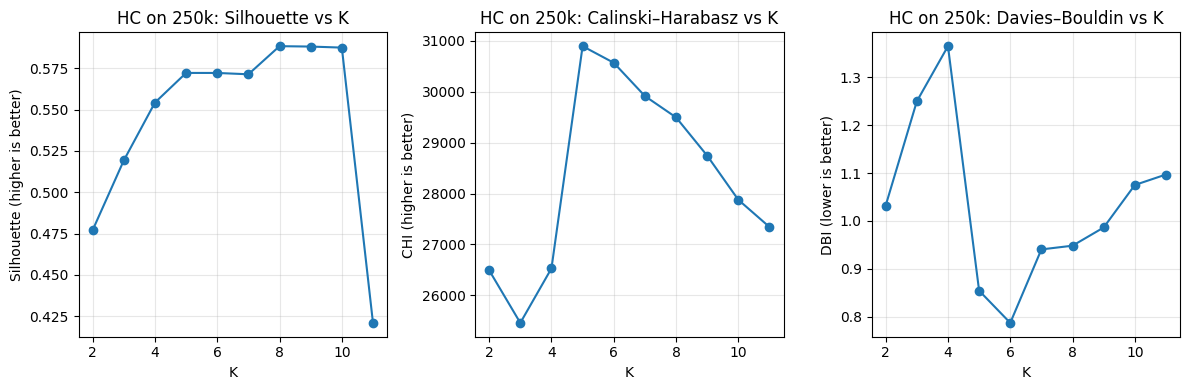

In [24]:
import matplotlib.pyplot as plt

# If your dataframe is named differently (e.g. hc_metrics_df),
# just replace `hc_250k_df` below with that name.
df = hc_250k_df

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# Silhouette
axes[0].plot(df["k"], df["silhouette"], marker="o")
axes[0].set_title("HC on 250k: Silhouette vs K")
axes[0].set_xlabel("K")
axes[0].set_ylabel("Silhouette (higher is better)")
axes[0].grid(True, alpha=0.3)

# Calinski–Harabasz
axes[1].plot(df["k"], df["CHI"], marker="o")
axes[1].set_title("HC on 250k: Calinski–Harabasz vs K")
axes[1].set_xlabel("K")
axes[1].set_ylabel("CHI (higher is better)")
axes[1].grid(True, alpha=0.3)

# Davies–Bouldin
axes[2].plot(df["k"], df["DBI"], marker="o")
axes[2].set_title("HC on 250k: Davies–Bouldin vs K")
axes[2].set_xlabel("K")
axes[2].set_ylabel("DBI (lower is better)")
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [1]:
print("h")

h


In [25]:
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering

# --- 1. Subsample (50k like before; change if you used a different size) ---
max_sample = 50_000
N = X_scaled.shape[0]
rng = np.random.RandomState(42)

if N > max_sample:
    sample_idx = rng.choice(N, size=max_sample, replace=False)
else:
    sample_idx = np.arange(N)

X_s = X_scaled[sample_idx]
df_s = cargo_windows_df.iloc[sample_idx].copy()

print("Subsample size:", X_s.shape[0])

# --- 2. Fit hierarchical clustering with K = 6 on the subsample ---
K_HC = 6
hc = AgglomerativeClustering(
    n_clusters=K_HC,
    linkage="ward",   # same as for metrics
)
labels_s = hc.fit_predict(X_s)

df_s["hc_k6_cluster"] = labels_s

# --- 3. Centroids in ORIGINAL feature units (from subsample) ---
hc_centroids_k6 = (
    df_s
    .groupby("hc_k6_cluster")[FEATURE_COLS]
    .mean()
    .sort_index()
)

hc_counts_k6 = (
    df_s["hc_k6_cluster"]
    .value_counts()
    .sort_index()
)

hc_centroids_with_counts = hc_centroids_k6.copy()
hc_centroids_with_counts["count_in_sample"] = hc_counts_k6

print("Hierarchical K=6 centroids (original feature means, on 50k subsample):")
display(hc_centroids_with_counts)


Subsample size: 50000
Hierarchical K=6 centroids (original feature means, on 50k subsample):


mean_sog_30min  frac_stopped_30min  frac_slow_30min  \
hc_k6_cluster                                                        
0                    0.051302            0.749850         0.916817   
1                    0.254869            0.081855         0.483114   
2                    0.235435            0.095375         0.537024   
3                    0.414367            0.000000         0.010860   
4                    0.001150            0.987667         1.000000   
5                    0.131954            0.002479         0.998291   

               mean_abs_turnrate_norm_per_min_30min  cog_spike_norm_30min  \
hc_k6_cluster                                                               
0                                          0.020962              0.300444   
1                                          0.009016              0.135068   
2                                          0.010493              0.154044   
3                                          0.001232              0.018556   
4                                          0.000815              0.011846   
5                                          0.001684              0.023810   

               mean_accel_norm_per_hr_30min  max_abs_accel_norm_per_hr_30min  \
hc_k6_cluster                                                                  
0                                  0.002306                         0.078672   
1                                 -0.470387                         0.844933   
2                                  0.550644                         0.942288   
3                                  0.002199                         0.073273   
4                                 -0.000296                         0.006916   
5                                 -0.006695                         0.075218   

               count_in_sample  
hc_k6_cluster                   
0                         7229  
1                         1747  
2                         1391  
3                        26273  
4                         9460  
5                         3900

In [26]:
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise_distances_argmin

# --- 0. Assumptions ---
# cargo_windows_df already exists
# FEATURE_COLS already defined
# X_scaled already computed with StandardScaler on FEATURE_COLS

K_HC = 6
max_sample = 50_000
N = X_scaled.shape[0]
rng = np.random.RandomState(42)

# --- 1. Subsample ONLY for fitting HC ---
if N > max_sample:
    sample_idx = rng.choice(N, size=max_sample, replace=False)
else:
    sample_idx = np.arange(N)

X_s = X_scaled[sample_idx]
df_s = cargo_windows_df.iloc[sample_idx].copy()

print("Subsample size for HC fit:", X_s.shape[0])

hc = AgglomerativeClustering(
    n_clusters=K_HC,
    linkage="ward",
)
labels_s = hc.fit_predict(X_s)
df_s["hc_k6_cluster"] = labels_s

# --- 2. Centroids in *scaled* space from the subsample ---
centroids_scaled = np.vstack([
    X_s[labels_s == k].mean(axis=0)
    for k in range(K_HC)
])
print("centroids_scaled shape:", centroids_scaled.shape)  # (6, 7)

# --- 3. Assign EVERY cargo window to the nearest centroid ---
full_labels = pairwise_distances_argmin(X_scaled, centroids_scaled)
cargo_windows_df["hc_k6_cluster"] = full_labels

print("Full-data HC K=6 cluster counts:")
print(cargo_windows_df["hc_k6_cluster"].value_counts().sort_index())

# --- 4. Final centroids in ORIGINAL feature units using ALL windows ---
hc_centroids_full_k6 = (
    cargo_windows_df
    .groupby("hc_k6_cluster")[FEATURE_COLS]
    .mean()
    .sort_index()
)

hc_counts_full_k6 = (
    cargo_windows_df["hc_k6_cluster"]
    .value_counts()
    .sort_index()
)

hc_centroids_full_k6["count"] = hc_counts_full_k6

print("\nHierarchical K=6 centroids on FULL cargo dataset:")
display(hc_centroids_full_k6)


Subsample size for HC fit: 50000
centroids_scaled shape: (6, 7)
Full-data HC K=6 cluster counts:
hc_k6_cluster
0     95117
1     27284
2     22738
3    443623
4    177377
5     78856
Name: count, dtype: int64

Hierarchical K=6 centroids on FULL cargo dataset:


mean_sog_30min  frac_stopped_30min  frac_slow_30min  \
hc_k6_cluster                                                        
0                    0.039717            0.777152         0.941777   
1                    0.257489            0.071532         0.475468   
2                    0.248091            0.105301         0.490031   
3                    0.415832            0.000000         0.005457   
4                    0.001006            0.994240         1.000000   
5                    0.134102            0.011354         0.976611   

               mean_abs_turnrate_norm_per_min_30min  cog_spike_norm_30min  \
hc_k6_cluster                                                               
0                                          0.024173              0.343284   
1                                          0.009081              0.136675   
2                                          0.011387              0.170764   
3                                          0.001324              0.019976   
4                                          0.001597              0.023581   
5                                          0.002425              0.034717   

               mean_accel_norm_per_hr_30min  max_abs_accel_norm_per_hr_30min  \
hc_k6_cluster                                                                  
0                                 -0.000350                         0.075838   
1                                 -0.493485                         0.866983   
2                                  0.563114                         1.005706   
3                                  0.001278                         0.071204   
4                                 -0.000288                         0.006678   
5                                 -0.002963                         0.103478   

                count  
hc_k6_cluster          
0               95117  
1               27284  
2               22738  
3              443623  
4              177377  
5               78856

In [27]:
hc_cluster_to_behavior = {
    0: "loiter_turning",
    1: "transit_decelerating",
    2: "transit_accelerating",
    3: "cruise_fast_steady",
    4: "stopped_static",
    5: "slow_cruise_loiter",
}

cargo_windows_df["behavior_hc_k6"] = (
    cargo_windows_df["hc_k6_cluster"].map(hc_cluster_to_behavior)
)


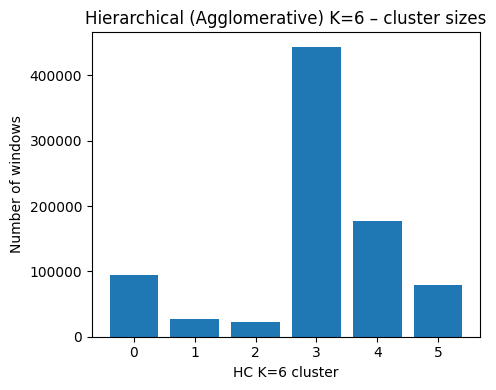

In [28]:
import matplotlib.pyplot as plt
import numpy as np

counts = cargo_windows_df["hc_k6_cluster"].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(5, 4))
ax.bar(counts.index, counts.values)
ax.set_xticks(counts.index)
ax.set_xlabel("HC K=6 cluster")
ax.set_ylabel("Number of windows")
ax.set_title("Hierarchical (Agglomerative) K=6 – cluster sizes")
plt.tight_layout()
plt.show()


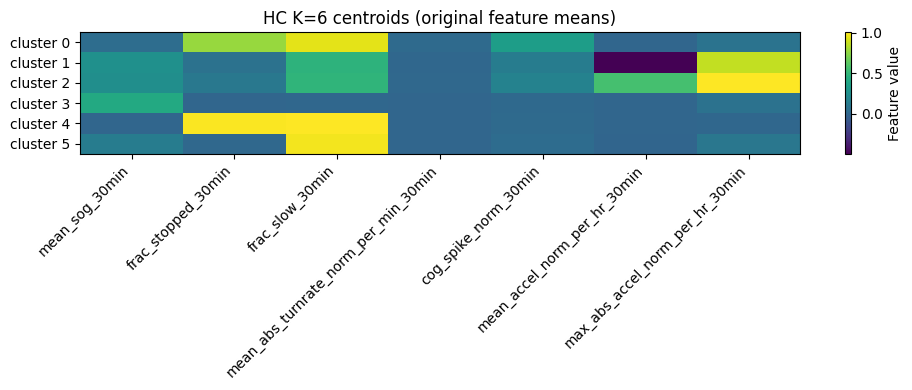

In [29]:
# table we printed already
hc_centroids_full_k6 = (
    cargo_windows_df
    .groupby("hc_k6_cluster")[FEATURE_COLS]
    .mean()
    .sort_index()
)

fig, ax = plt.subplots(figsize=(10, 4))
im = ax.imshow(hc_centroids_full_k6.values, aspect="auto")

ax.set_xticks(np.arange(len(FEATURE_COLS)))
ax.set_xticklabels(FEATURE_COLS, rotation=45, ha="right")
ax.set_yticks(np.arange(6))
ax.set_yticklabels([f"cluster {k}" for k in range(6)])

ax.set_title("HC K=6 centroids (original feature means)")
cbar = fig.colorbar(im, ax=ax)
cbar.set_label("Feature value")

plt.tight_layout()
plt.show()


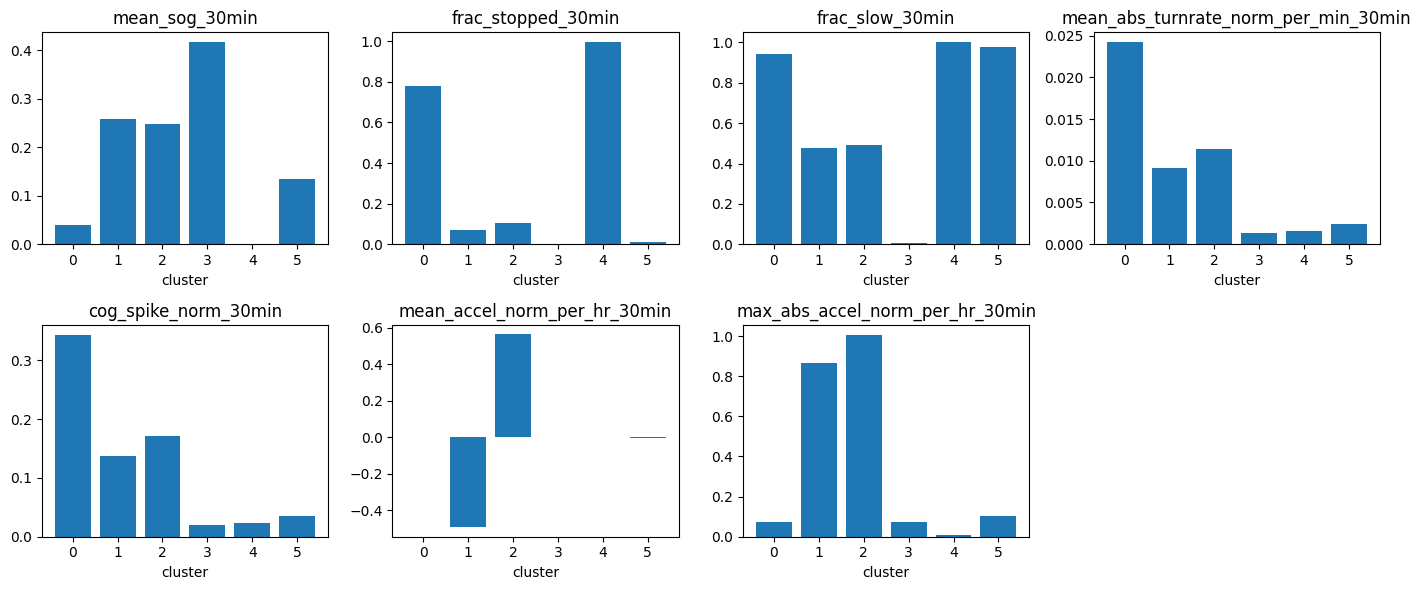

In [30]:
fig, axes = plt.subplots(2, 4, figsize=(14, 6))
axes = axes.ravel()

for i, feat in enumerate(FEATURE_COLS):
    ax = axes[i]
    ax.bar(range(6), hc_centroids_full_k6[feat].values)
    ax.set_xticks(range(6))
    ax.set_xticklabels([str(k) for k in range(6)])
    ax.set_xlabel("cluster")
    ax.set_title(feat)

# hide any unused subplot (since we have 7 features but 8 slots)
for j in range(len(FEATURE_COLS), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()


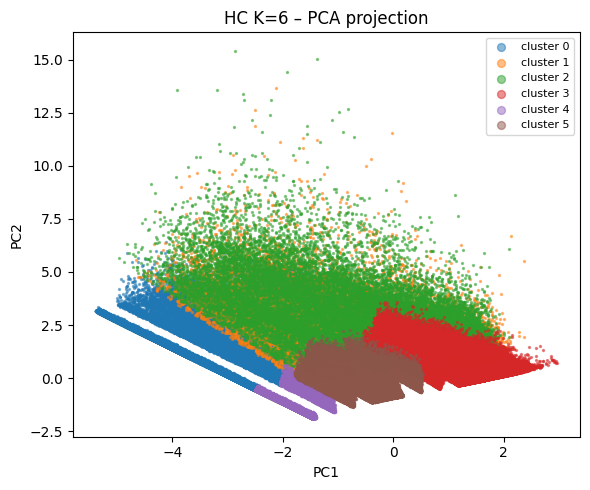

In [31]:
from sklearn.decomposition import PCA

X = cargo_windows_df[FEATURE_COLS].to_numpy()

# standardize again here just to be safe
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

labels = cargo_windows_df["hc_k6_cluster"].to_numpy()

fig, ax = plt.subplots(figsize=(6, 5))

for k in range(6):
    mask = labels == k
    ax.scatter(
        X_pca[mask, 0],
        X_pca[mask, 1],
        s=2,
        alpha=0.5,
        label=f"cluster {k}",
    )

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("HC K=6 – PCA projection")
ax.legend(markerscale=4, fontsize=8)
plt.tight_layout()
plt.show()


In [32]:
import folium

# ========= 1. Pick a vessel =========
# You can hard-code an MMSI or use the most common one:
# mmsi_to_plot = 538007560   # <- your choice
mmsi_to_plot = cargo_windows_df["mmsi"].mode()[0]

vessel_df = (
    cargo_windows_df[cargo_windows_df["mmsi"] == mmsi_to_plot]
    .sort_values("start_time")
    .reset_index(drop=True)
)

print("MMSI plotted:", mmsi_to_plot, "windows:", len(vessel_df))

# ========= 2. Base map centered on vessel =========
# Use your *original* lat/lon columns (not the normalized ones)
center_lat = vessel_df["lat_center"].mean()
center_lon = vessel_df["lon_center"].mean()

m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=9,
    tiles="CartoDB positron",
)

# ========= 3. Grey trajectory polyline =========
track_coords = list(zip(vessel_df["lat_center"], vessel_df["lon_center"]))
folium.PolyLine(
    track_coords,
    color="lightgray",
    weight=2,
    opacity=0.7,
).add_to(m)

# ========= 4. Coloured points by hierarchical behaviour =========
behavior_colors = {
    "cruise_fast_steady": "blue",
    "stopped_static": "red",
    "loiter_turning": "purple",
    "transit_accelerating": "green",
    "transit_decelerating": "orange",
    "slow_cruise_loiter": "gray",
}

for _, row in vessel_df.iterrows():
    beh = row["behavior_hc_k6"]
    color = behavior_colors.get(beh, "black")

    popup_html = f"""
    <b>Time:</b> {row['start_time']}<br>
    <b>Behaviour (HC K=6):</b> {beh}<br>
    <b>HC cluster:</b> {row['hc_k6_cluster']}<br>
    <b>Mean SOG 30min:</b> {row['mean_sog_30min']:.3f} kn<br>
    <b>Frac stopped 30min:</b> {row['frac_stopped_30min']:.3f}<br>
    <b>Frac slow 30min:</b> {row['frac_slow_30min']:.3f}<br>
    <b>Mean abs turnrate norm/min:</b> {row['mean_abs_turnrate_norm_per_min_30min']:.5f}<br>
    <b>COG spike norm 30min:</b> {row['cog_spike_norm_30min']:.5f}<br>
    <b>Mean accel norm/hr:</b> {row['mean_accel_norm_per_hr_30min']:.5f}<br>
    <b>Max abs accel norm/hr:</b> {row['max_abs_accel_norm_per_hr_30min']:.5f}<br>
    """

    folium.CircleMarker(
        location=[row["lat_center"], row["lon_center"]],
        radius=3,
        color=color,
        fill=True,
        fill_opacity=0.8,
        popup=folium.Popup(popup_html, max_width=300),
    ).add_to(m)

# ========= 5. Save to HTML =========
outfile = f"hierarchical_hc_k6_mmsi_{mmsi_to_plot}.html"
m.save(outfile)
print("Saved map to:", outfile)

# Optionally display in notebook as well
m


MMSI plotted: 316048574 windows: 2384


KeyError: 'lat_center'

In [33]:
cargo_windows_df

mmsi  vessel_type          start_time  lat_center_norm  \
0       538007560           70 2024-01-09 13:08:22         0.213278   
1       538007560           70 2024-01-09 13:38:22         0.214782   
2       538007560           70 2024-01-09 14:08:22         0.215992   
3       538007560           70 2024-01-09 14:38:22         0.217250   
4       538007560           70 2024-01-09 15:08:22         0.217995   
...           ...          ...                 ...              ...   
844990  477594100           70 2024-01-31 08:07:26         0.661781   
844991  477594100           70 2024-01-31 08:37:26         0.662787   
844992  477594100           70 2024-01-31 09:07:26         0.663763   
844993  477594100           70 2024-01-31 09:37:26         0.664721   
844994  477594100           70 2024-01-31 10:07:26         0.665667   

        lon_center_norm  mean_sog_30min  frac_stopped_30min  frac_slow_30min  \
0              0.702955        0.308888                 0.0         0.000000   
1              0.703477        0.283858                 0.0         0.333333   
2              0.703914        0.238467                 0.0         0.666667   
3              0.704403        0.236151                 0.0         0.666667   
4              0.704721        0.103955                 0.0         1.000000   
...                 ...             ...                 ...              ...   
844990         0.350870        0.348109                 0.0         0.000000   
844991         0.349767        0.341685                 0.0         0.000000   
844992         0.348658        0.347050                 0.0         0.000000   
844993         0.347548        0.337589                 0.0         0.000000   
844994         0.346451        0.338167                 0.0         0.000000   

        mean_abs_turnrate_norm_per_min_30min  cog_spike_norm_30min  \
0                                   0.000428              0.008240   
1                                   0.000580              0.009661   
2                                   0.001162              0.017071   
3                                   0.000165              0.003026   
4                                   0.000905              0.015240   
...                                      ...                   ...   
844990                              0.000863              0.013131   
844991                              0.001500              0.019022   
844992                              0.001069              0.015733   
844993                              0.000220              0.003583   
844994                              0.000479              0.005637   

        mean_accel_norm_per_hr_30min  max_abs_accel_norm_per_hr_30min  \
0                          -0.002000                         0.047987   
1                          -0.146448                         0.470835   
2                           0.198551                         0.461793   
3                          -0.227500                         0.240714   
4                           0.044325                         0.154201   
...                              ...                              ...   
844990                     -0.026742                         0.040563   
844991                      0.009525                         0.054359   
844992                      0.013695                         0.107143   
844993                     -0.026703                         0.065000   
844994                     -0.074797                         0.111407   

        gmm_k7_cluster  gmm_k7_max_prob  gmm_k7_margin  hc_k6_cluster  \
0                    0         1.000000       1.000000              3   
1                    6         1.000000       1.000000              3   
2                    6         1.000000       1.000000              5   
3                    6         1.000000       1.000000              5   
4                    5         0.999999       0.999999              5   
...                ...              ...    

In [34]:
# --- 1. Denormalize window centers back to real degrees ---
LAT_MIN, LAT_MAX = 20.0, 60.0
LON_MIN, LON_MAX = -160.0, -60.0

cargo_windows_df["lat_center"] = (
    cargo_windows_df["lat_center_norm"] * (LAT_MAX - LAT_MIN) + LAT_MIN
)
cargo_windows_df["lon_center"] = (
    cargo_windows_df["lon_center_norm"] * (LON_MAX - LON_MIN) + LON_MIN
)


In [35]:
import folium

LAT_COL = "lat_center"
LON_COL = "lon_center"

# Pick a vessel to visualize
mmsi_to_plot = cargo_windows_df["mmsi"].mode()[0]   # or hard-code an MMSI
vessel_df = (
    cargo_windows_df[cargo_windows_df["mmsi"] == mmsi_to_plot]
    .sort_values("start_time")
    .reset_index(drop=True)
)

print("MMSI plotted:", mmsi_to_plot, "windows:", len(vessel_df))

# Center map
center_lat = vessel_df[LAT_COL].mean()
center_lon = vessel_df[LON_COL].mean()

m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=9,
    tiles="CartoDB positron",
)

# Grey track polyline
track_coords = list(zip(vessel_df[LAT_COL], vessel_df[LON_COL]))
folium.PolyLine(track_coords, color="lightgray", weight=2, opacity=0.7).add_to(m)

# Colours by hierarchical behaviour
behavior_colors = {
    "cruise_fast_steady": "blue",
    "stopped_static": "red",
    "loiter_turning": "purple",
    "transit_accelerating": "green",
    "transit_decelerating": "orange",
    "slow_cruise_loiter": "gray",
}

for _, row in vessel_df.iterrows():
    beh = row["behavior_hc_k6"]
    color = behavior_colors.get(beh, "black")

    popup_html = f"""
    <b>Time:</b> {row['start_time']}<br>
    <b>Behaviour (HC K=6):</b> {beh}<br>
    <b>HC cluster:</b> {row['hc_k6_cluster']}<br>
    <b>Mean SOG 30min:</b> {row['mean_sog_30min']:.3f} kn<br>
    <b>Frac stopped 30min:</b> {row['frac_stopped_30min']:.3f}<br>
    <b>Frac slow 30min:</b> {row['frac_slow_30min']:.3f}<br>
    <b>Mean abs turnrate norm/min:</b> {row['mean_abs_turnrate_norm_per_min_30min']:.5f}<br>
    <b>COG spike norm 30min:</b> {row['cog_spike_norm_30min']:.5f}<br>
    <b>Mean accel norm/hr:</b> {row['mean_accel_norm_per_hr_30min']:.5f}<br>
    <b>Max abs accel norm/hr:</b> {row['max_abs_accel_norm_per_hr_30min']:.5f}<br>
    """

    folium.CircleMarker(
        location=[row[LAT_COL], row[LON_COL]],
        radius=3,
        color=color,
        fill=True,
        fill_opacity=0.8,
        popup=folium.Popup(popup_html, max_width=300),
    ).add_to(m)

# Save to HTML
outfile = f"hierarchical_hc_k6_mmsi_{mmsi_to_plot}.html"
m.save(outfile)
print("Saved map to:", outfile)

m


MMSI plotted: 316048574 windows: 2384
Saved map to: hierarchical_hc_k6_mmsi_316048574.html


In [36]:
import pandas as pd
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# ---- column names (edit these if needed) ----
gmm_col = "gmm_k7_cluster"
hc_col  = "hc_k6_cluster"

# Drop any rows that might have NaNs in either label (just in case)
df_common = cargo_windows_df.dropna(subset=[gmm_col, hc_col]).copy()

# 1. Raw confusion matrix (counts)
cluster_ct_counts = pd.crosstab(df_common[gmm_col], df_common[hc_col])
print("GMM vs HC cluster contingency table (counts):")
display(cluster_ct_counts)

# 2. Normalized confusion (fraction of all windows)
cluster_ct_frac = pd.crosstab(df_common[gmm_col], df_common[hc_col],
                              normalize="all")
print("GMM vs HC cluster contingency table (fraction of all windows):")
display(cluster_ct_frac)

# 3. Global clustering-agreement metrics (label-invariant)
ari = adjusted_rand_score(df_common[gmm_col], df_common[hc_col])
nmi = normalized_mutual_info_score(df_common[gmm_col], df_common[hc_col])

print(f"\nAdjusted Rand Index (ARI): {ari:.3f}  (1 = perfect, 0 ~ random)")
print(f"Normalized Mutual Information (NMI): {nmi:.3f}  (1 = perfect, 0 ~ no info)")

# 4. "Best mapping" agreement: for each GMM cluster, map it to the HC cluster
#    where most of its points fall, then see what fraction of windows match.
mapping = {}
for g in cluster_ct_counts.index:
    best_h = cluster_ct_counts.loc[g].idxmax()
    mapping[g] = best_h

df_common["hc_from_gmm"] = df_common[gmm_col].map(mapping)
best_mapping_agreement = (df_common["hc_from_gmm"] == df_common[hc_col]).mean()

print("\nHeuristic best one-way mapping GMM→HC:")
print("  mapping:", mapping)
print(f"  fraction of windows where mapped label == true HC label: {best_mapping_agreement:.3f}")


GMM vs HC cluster contingency table (counts):


hc_k6_cluster       0      1      2       3       4      5
gmm_k7_cluster                                            
0                   0      0      0  361165       0      0
1               52409      0      0       0  165335      0
2               23413      0      0       0   11540   2326
3                2115    108   4229      68       0      0
4                5470   5137   3383       0     502    685
5                   0      0      0       0       0  61962
6               11710  22039  15126   82390       0  13883

GMM vs HC cluster contingency table (fraction of all windows):


hc_k6_cluster          0         1         2         3         4         5
gmm_k7_cluster                                                            
0               0.000000  0.000000  0.000000  0.427417  0.000000  0.000000
1               0.062023  0.000000  0.000000  0.000000  0.195664  0.000000
2               0.027708  0.000000  0.000000  0.000000  0.013657  0.002753
3               0.002503  0.000128  0.005005  0.000080  0.000000  0.000000
4               0.006473  0.006079  0.004004  0.000000  0.000594  0.000811
5               0.000000  0.000000  0.000000  0.000000  0.000000  0.073328
6               0.013858  0.026082  0.017901  0.097504  0.000000  0.016430


Adjusted Rand Index (ARI): 0.666  (1 = perfect, 0 ~ random)
Normalized Mutual Information (NMI): 0.654  (1 = perfect, 0 ~ no info)

Heuristic best one-way mapping GMM→HC:
  mapping: {0: np.int64(3), 1: np.int64(4), 2: np.int64(0), 3: np.int64(2), 4: np.int64(0), 5: np.int64(5), 6: np.int64(3)}
  fraction of windows where mapped label == true HC label: 0.833


In [38]:
import pandas as pd

# ---- load your combined KMeans + GMM labels ----
labels_df = pd.read_pickle("cargo_behavior_labels_kmeans_gmm.pkl")
# or: labels_df = pd.read_csv("cargo_behavior_labels_kmeans_gmm.csv")

print("labels_df shape:", labels_df.shape)
print(labels_df.columns)

# ---- grab HC labels from the current cargo_windows_df ----
hc_cols = cargo_windows_df[["mmsi", "start_time",
                            "hc_k6_cluster", "behavior_hc_k6"]].copy()

# ---- merge on MMSI + start_time to align rows ----
merged = labels_df.merge(
    hc_cols,
    on=["mmsi", "start_time"],
    how="inner",
    suffixes=("", "_hc"),
)

print("merged shape:", merged.shape)


labels_df shape: (844995, 19)
Index(['mmsi', 'start_time', 'lat_center_norm', 'lon_center_norm', 'lat_deg',
       'lon_deg', 'mean_sog_30min', 'frac_stopped_30min', 'frac_slow_30min',
       'mean_abs_turnrate_norm_per_min_30min', 'cog_spike_norm_30min',
       'mean_accel_norm_per_hr_30min', 'max_abs_accel_norm_per_hr_30min',
       'cluster_k6', 'behavior_k6', 'gmm_cluster', 'behavior_gmm_k7',
       'gmm_max_prob', 'gmm_margin'],
      dtype='object')
merged shape: (844995, 21)


In [39]:
# Overall agreement: behaviour labels match or not
agree_hc_vs_gmm = (merged["behavior_hc_k6"] == merged["behavior_gmm_k7"]).mean()
agree_hc_vs_km  = (merged["behavior_hc_k6"] == merged["behavior_k6"]).mean()

print(f"Overall behaviour agreement HC vs GMM : {agree_hc_vs_gmm:.3%}")
print(f"Overall behaviour agreement HC vs KMeans: {agree_hc_vs_km:.3%}")


Overall behaviour agreement HC vs GMM : 62.308%
Overall behaviour agreement HC vs KMeans: 97.991%


In [40]:
# Confusion matrix (rows = GMM behaviour, cols = HC behaviour), normalized per row
gmm_vs_hc = pd.crosstab(
    merged["behavior_gmm_k7"],
    merged["behavior_hc_k6"],
    normalize="index"
)

print("Row-normalized behaviour confusion: GMM (rows) vs HC (cols)")
display(gmm_vs_hc)

# Extract the diagonal = % where HC matches GMM for each behaviour
per_beh_gmm = {}

for beh in gmm_vs_hc.index:
    per_beh_gmm[beh] = gmm_vs_hc.loc[beh, beh] if beh in gmm_vs_hc.columns else 0.0

print("\nPer-behaviour agreement (HC vs GMM):")
for beh, frac in per_beh_gmm.items():
    print(f"  {beh:22s}  {frac:.3%}  (HC label == GMM label)")


Row-normalized behaviour confusion: GMM (rows) vs HC (cols)


behavior_hc_k6                 cruise_fast_steady  loiter_turning  \
behavior_gmm_k7                                                     
cruise_decelerating_turning              0.567628        0.080676   
cruise_fast_steady                       1.000000        0.000000   
loiter_decelerating_maneuver             0.000000        0.360414   
loiter_sharp_turns                       0.000000        0.628048   
slow_cruise_steady                       0.000000        0.000000   
stopped_static                           0.000000        0.240691   
transit_accelerating_maneuver            0.010429        0.324387   

behavior_hc_k6                 slow_cruise_loiter  stopped_static  \
behavior_gmm_k7                                                     
cruise_decelerating_turning              0.095647        0.000000   
cruise_fast_steady                       0.000000        0.000000   
loiter_decelerating_maneuver             0.045134        0.033076   
loiter_sharp_turns                       0.062394        0.309558   
slow_cruise_steady                       1.000000        0.000000   
stopped_static                           0.000000        0.759309   
transit_accelerating_maneuver            0.000000        0.000000   

behavior_hc_k6                 transit_accelerating  transit_decelerating  
behavior_gmm_k7                                                            
cruise_decelerating_turning                0.104211              0.151838  
cruise_fast_steady                         0.000000              0.000000  
loiter_decelerating_maneuver               0.222903              0.338473  
loiter_sharp_turns                         0.000000              0.000000  
slow_cruise_steady                         0.000000              0.000000  
stopped_static                             0.000000              0.000000  
transit_accelerating_maneuver              0.648620              0.016564


Per-behaviour agreement (HC vs GMM):
  cruise_decelerating_turning  0.000%  (HC label == GMM label)
  cruise_fast_steady      100.000%  (HC label == GMM label)
  loiter_decelerating_maneuver  0.000%  (HC label == GMM label)
  loiter_sharp_turns      0.000%  (HC label == GMM label)
  slow_cruise_steady      0.000%  (HC label == GMM label)
  stopped_static          75.931%  (HC label == GMM label)
  transit_accelerating_maneuver  0.000%  (HC label == GMM label)


In [42]:
import pandas as pd

# 1. Load the existing file with KMeans + GMM labels
labels_df = pd.read_pickle("cargo_behavior_labels_kmeans_gmm.pkl")
# or, if you prefer CSV:
# labels_df = pd.read_csv("cargo_behavior_labels_kmeans_gmm.csv")

print("labels_df columns:", labels_df.columns)

# 2. Take the HC labels from your current cargo_windows_df
hc_cols = cargo_windows_df[[
    "mmsi",
    "start_time",
    "hc_k6_cluster",   # numeric HC cluster id
    "behavior_hc_k6",  # semantic behaviour from HC
]].copy()

# (optional but good): make sure start_time dtypes match
# labels_df["start_time"] = pd.to_datetime(labels_df["start_time"])
# hc_cols["start_time"]   = pd.to_datetime(hc_cols["start_time"])

# 3. Merge HC info into the labels_df
labels_with_hc = labels_df.merge(
    hc_cols,
    on=["mmsi", "start_time"],
    how="left",              # keep all rows from labels_df
)

print("labels_with_hc columns:", labels_with_hc.columns)
print(labels_with_hc.head())

# 4. Save back out with a new name (so you keep the original too)
labels_with_hc.to_pickle("cargo_behavior_labels_kmeans_gmm_hc.pkl")
labels_with_hc.to_csv("cargo_behavior_labels_kmeans_gmm_hc.csv", index=False)

print("Saved with HC info to:")
print("  cargo_behavior_labels_kmeans_gmm_hc.pkl")
print("  cargo_behavior_labels_kmeans_gmm_hc.csv")


labels_df columns: Index(['mmsi', 'start_time', 'lat_center_norm', 'lon_center_norm', 'lat_deg',
       'lon_deg', 'mean_sog_30min', 'frac_stopped_30min', 'frac_slow_30min',
       'mean_abs_turnrate_norm_per_min_30min', 'cog_spike_norm_30min',
       'mean_accel_norm_per_hr_30min', 'max_abs_accel_norm_per_hr_30min',
       'cluster_k6', 'behavior_k6', 'gmm_cluster', 'behavior_gmm_k7',
       'gmm_max_prob', 'gmm_margin'],
      dtype='object')
labels_with_hc columns: Index(['mmsi', 'start_time', 'lat_center_norm', 'lon_center_norm', 'lat_deg',
       'lon_deg', 'mean_sog_30min', 'frac_stopped_30min', 'frac_slow_30min',
       'mean_abs_turnrate_norm_per_min_30min', 'cog_spike_norm_30min',
       'mean_accel_norm_per_hr_30min', 'max_abs_accel_norm_per_hr_30min',
       'cluster_k6', 'behavior_k6', 'gmm_cluster', 'behavior_gmm_k7',
       'gmm_max_prob', 'gmm_margin', 'hc_k6_cluster', 'behavior_hc_k6'],
      dtype='object')
        mmsi          start_time  lat_center_norm  lon_center_

In [1]:
import pickle

with open("traj_list.pkl", "rb") as f:
    traj_list = pickle.load(f)

print("Type of traj_list:", type(traj_list))
print("Number of trajectories:", len(traj_list))

# Look at the first trajectory
first_traj = traj_list[0]
print("Type of first trajectory:", type(first_traj))

# If it’s a numpy array:
try:
    import numpy as np
    if isinstance(first_traj, np.ndarray):
        print("Shape of first trajectory array:", first_traj.shape)
        print("First row:", first_traj[0])
except ImportError:
    pass

# If trajectories are stored as DataFrames:
try:
    import pandas as pd
    if isinstance(first_traj, pd.DataFrame):
        print("Columns:", first_traj.columns)
        print(first_traj.head())
except ImportError:
    pass


Type of traj_list: <class 'list'>
Number of trajectories: 3
Type of first trajectory: <class 'tuple'>


In [2]:
import pickle
import numpy as np
import pandas as pd

with open("traj_list.pkl", "rb") as f:
    traj_list = pickle.load(f)

print("Type of traj_list:", type(traj_list))
print("Number of trajectories:", len(traj_list))

# Look at the first trajectory
traj0 = traj_list[0]
print("\nType of first trajectory:", type(traj0))
print("Length of first trajectory tuple:", len(traj0))

# Inspect each element in the tuple
for i, part in enumerate(traj0):
    print(f"\n--- Element {i} ---")
    print("  type:", type(part))

    # If it's a numpy array, show shape and a few rows
    if isinstance(part, np.ndarray):
        print("  shape:", part.shape)
        print("  first 3 rows:\n", part[:3])

    # If it's a pandas DataFrame, show head
    if isinstance(part, pd.DataFrame):
        print("  columns:", part.columns.tolist())
        print(part.head())

    # If it's something simple (int, str, etc.), just print it
    if not isinstance(part, (np.ndarray, pd.DataFrame)):
        print("  value:", part)


Type of traj_list: <class 'list'>
Number of trajectories: 3

Type of first trajectory: <class 'tuple'>
Length of first trajectory tuple: 2

--- Element 0 ---
  type: <class 'int'>
  value: 538009560

--- Element 1 ---
  type: <class 'pandas.core.frame.DataFrame'>
  columns: ['mmsi', 't_unix', 'lat_deg', 'lon_deg', 'sog_knots', 'cog_deg']
            mmsi      t_unix    lat_deg    lon_deg  sog_knots     cog_deg
24120  538009560  1708855201  38.850735 -75.066162  10.200000  336.600006
24121  538009560  1708855801  38.890438 -75.081596  17.190908  340.518158
24122  538009560  1708856401  38.934414 -75.103600  17.300001  337.399994
24123  538009560  1708857001  38.979473 -75.127808  18.000000  337.581818
24124  538009560  1708857601  39.024929 -75.152275  17.500000  336.363647


In [3]:
for idx, (mmsi, df_traj) in enumerate(traj_list):
    print(f"\n=== Trajectory {idx} ===")
    print("MMSI:", mmsi)
    print("DataFrame shape:", df_traj.shape)
    print(df_traj.head())



=== Trajectory 0 ===
MMSI: 538009560
DataFrame shape: (60, 6)
            mmsi      t_unix    lat_deg    lon_deg  sog_knots     cog_deg
24120  538009560  1708855201  38.850735 -75.066162  10.200000  336.600006
24121  538009560  1708855801  38.890438 -75.081596  17.190908  340.518158
24122  538009560  1708856401  38.934414 -75.103600  17.300001  337.399994
24123  538009560  1708857001  38.979473 -75.127808  18.000000  337.581818
24124  538009560  1708857601  39.024929 -75.152275  17.500000  336.363647

=== Trajectory 1 ===
MMSI: 311001084.0
DataFrame shape: (30, 6)
            mmsi      t_unix    lat_deg    lon_deg  sog_knots     cog_deg
23400  311001084  1708855202  39.141430 -75.237526  14.400001  145.000000
23401  311001084  1708855802  39.108994 -75.207588  14.292307  143.076920
23402  311001084  1708856402  39.075638 -75.181267  14.127273  159.545456
23403  311001084  1708857002  39.039124 -75.162483  13.926866  156.000000
23404  311001084  1708857602  39.003555 -75.143044  13.800

In [4]:
import pickle
import numpy as np
import pandas as pd

# ------------- Load the trajectories -------------
with open("traj_list.pkl", "rb") as f:
    traj_list = pickle.load(f)

print("Number of trajectories:", len(traj_list))

# ------------- Feature names (same as cargo windows) -------------
FEATURE_COLS = [
    "mean_sog_30min",
    "frac_stopped_30min",
    "frac_slow_30min",
    "mean_abs_turnrate_norm_per_min_30min",
    "cog_spike_norm_30min",
    "mean_accel_norm_per_hr_30min",
    "max_abs_accel_norm_per_hr_30min",
]

# ------------- Per-trajectory feature computation -------------

def compute_traj_features_whole(
    traj_df: pd.DataFrame,
    stop_knots: float = 0.5,
    slow_knots: float = 4.0,
    speed_max: float = 30.0,
) -> dict:
    """
    Compute the 7-D feature vector for ONE trajectory (all points).
    traj_df must have columns:
        't_unix', 'lat_deg', 'lon_deg', 'sog_knots', 'cog_deg'
    """
    df = traj_df.copy().sort_values("t_unix")

    # --- time in seconds ---
    df["timestamp"] = pd.to_datetime(df["t_unix"], unit="s")
    df["dt_sec"] = df["timestamp"].diff().dt.total_seconds()
    df["dt_sec"] = df["dt_sec"].fillna(0.0).clip(lower=1.0)

    # --- heading / turn rate ---
    delta_cog = df["cog_deg"].diff()
    # wrap to [-180, 180]
    delta_cog = (delta_cog + 180) % 360 - 180
    delta_cog = delta_cog.fillna(0.0)

    turnrate_deg_per_min = (delta_cog / df["dt_sec"]) * 60.0
    turnrate_norm_per_min = np.abs(turnrate_deg_per_min) / 360.0

    # COG spikes (sum of normalized heading jumps)
    cog_spike_norm = np.abs(delta_cog) / 360.0

    # --- acceleration from SOG ---
    delta_sog = df["sog_knots"].diff().fillna(0.0)
    accel_knots_per_hr = (delta_sog / df["dt_sec"]) * 3600.0
    accel_norm_per_hr = accel_knots_per_hr / speed_max

    # --- speed fractions ---
    sog = df["sog_knots"].to_numpy()
    n = len(sog)
    frac_stopped = (sog <= stop_knots).sum() / n
    frac_slow    = (sog <= slow_knots).sum() / n

    # --- aggregate over trajectory ---
    feat = {
        "mean_sog_30min": sog.mean(),
        "frac_stopped_30min": frac_stopped,
        "frac_slow_30min": frac_slow,
        "mean_abs_turnrate_norm_per_min_30min": np.abs(turnrate_norm_per_min).mean(),
        "cog_spike_norm_30min": cog_spike_norm.sum(),
        "mean_accel_norm_per_hr_30min": accel_norm_per_hr.mean(),
        "max_abs_accel_norm_per_hr_30min": np.abs(accel_norm_per_hr).max(),
    }
    return feat

# ------------- Apply to all trajectories -------------

feature_rows = []

for traj_index, (mmsi, df_traj) in enumerate(traj_list):
    feats = compute_traj_features_whole(df_traj)
    feats["mmsi"] = mmsi
    feats["traj_index"] = traj_index
    feature_rows.append(feats)

features_df = pd.DataFrame(feature_rows)

print("\nComputed features for all trajectories:")
print(features_df)

# If you want to see just the 7 feature columns:
print("\nFeature columns only:")
print(features_df[["traj_index", "mmsi"] + FEATURE_COLS])


Number of trajectories: 3

Computed features for all trajectories:
   mean_sog_30min  frac_stopped_30min  frac_slow_30min  \
0       14.224336            0.000000         0.016667   
1       13.244120            0.000000         0.000000   
2        5.083971            0.133333         0.200000   

   mean_abs_turnrate_norm_per_min_30min  cog_spike_norm_30min  \
0                              0.003718              2.580819   
1                              0.000962              0.288739   
2                              0.004361              1.308171   

   mean_accel_norm_per_hr_30min  max_abs_accel_norm_per_hr_30min         mmsi  \
0                      0.056318                         1.510607  538009560.0   
1                      0.024758                         0.920000  311001084.0   
2                      0.004689                         0.894783  338703000.0   

   traj_index  
0           0  
1           1  
2           2  

Feature columns only:
   traj_index         mmsi 

In [5]:
import pandas as pd

# Make sure FEATURE_COLS and compute_traj_features_whole are already defined
FEATURE_COLS = [
    "mean_sog_30min",
    "frac_stopped_30min",
    "frac_slow_30min",
    "mean_abs_turnrate_norm_per_min_30min",
    "cog_spike_norm_30min",
    "mean_accel_norm_per_hr_30min",
    "max_abs_accel_norm_per_hr_30min",
]

# List to collect augmented trajectories
augmented_trajs = []

for traj_index, (mmsi, df_traj) in enumerate(traj_list):
    print(f"\n=== Trajectory {traj_index} (MMSI {mmsi}) ===")

    # 1) Compute features for the whole trajectory
    feats = compute_traj_features_whole(df_traj)

    # 2) Copy original trajectory and add feature columns
    df_aug = df_traj.copy()
    df_aug["traj_index"] = traj_index  # keep track of which traj this row is from

    # add each feature as a constant column for this trajectory
    for feat_name, feat_value in feats.items():
        df_aug[feat_name] = feat_value

    # also keep MMSI explicitly (even though it's already a column)
    df_aug["mmsi_from_tuple"] = mmsi

    # 3) Print first 20 rows for this trajectory
    print(df_aug.head(20))

    # 4) Store for later concatenation
    augmented_trajs.append(df_aug)

# 5) Concatenate all 3 trajectories into one dataframe
all_trajs_with_features = pd.concat(augmented_trajs, ignore_index=True)

print("\nCombined dataframe shape:", all_trajs_with_features.shape)

# 6) Save to CSV for inspection
csv_path = "three_trajs_with_behavior_features.csv"
all_trajs_with_features.to_csv(csv_path, index=False)
print(f"Saved combined trajectories + features to: {csv_path}")



=== Trajectory 0 (MMSI 538009560) ===
            mmsi      t_unix    lat_deg    lon_deg  sog_knots     cog_deg  \
24120  538009560  1708855201  38.850735 -75.066162  10.200000  336.600006   
24121  538009560  1708855801  38.890438 -75.081596  17.190908  340.518158   
24122  538009560  1708856401  38.934414 -75.103600  17.300001  337.399994   
24123  538009560  1708857001  38.979473 -75.127808  18.000000  337.581818   
24124  538009560  1708857601  39.024929 -75.152275  17.500000  336.363647   
24125  538009560  1708858201  39.069839 -75.177361  17.581818  336.390900   
24126  538009560  1708858801  39.111057 -75.209160  17.400000  324.899994   
24127  538009560  1708859401  39.150326 -75.244743  17.300001  325.518188   
24128  538009560  1708860001  39.191299 -75.278618  17.750822  336.245880   
24129  538009560  1708860601  39.235317 -75.305603  17.223078  317.876923   
24130  538009560  1708861201  39.271099 -75.345268  17.360655  318.391815   
24131  538009560  1708861801  39.3068

In [6]:
import pickle
import numpy as np
import pandas as pd

# -------------------------------------------------------
# 1. Load trajectories (list of 3 tuples: (mmsi, df))
# -------------------------------------------------------
with open("traj_list.pkl", "rb") as f:
    traj_list = pickle.load(f)

print(f"Number of trajectories: {len(traj_list)}")


# -------------------------------------------------------
# 2. Constants + small helpers (only for SOG / COG)
# -------------------------------------------------------
SOG_MAX = 30.0           # knots, same as in cargo work
STOP_THRESH_KTS = 0.5    # below this: stopped
SLOW_THRESH_KTS = 5.0    # below this: slow

STOP_THRESH_NORM = STOP_THRESH_KTS / SOG_MAX
SLOW_THRESH_NORM = SLOW_THRESH_KTS / SOG_MAX


def wrap_angle_unit(d_cog_norm: np.ndarray) -> np.ndarray:
    """
    Wrap differences in normalized heading (0..1) to [-0.5, 0.5].
    """
    return (d_cog_norm + 0.5) % 1.0 - 0.5


# -------------------------------------------------------
# 3. Feature computation for ONE 30-min window (on a DF slice)
# -------------------------------------------------------
def compute_window_features(df_win: pd.DataFrame) -> dict:
    """
    df_win: slice of ONE trajectory, already restricted to a 30-min window.
            columns: ['mmsi','t_unix','lat_deg','lon_deg','sog_knots','cog_deg']
    Returns the 7 behaviour features for this window.
    """
    t = df_win["t_unix"].to_numpy(dtype=float)

    # --- SOG in normalized units (0..1) ---
    sog_kts = df_win["sog_knots"].to_numpy(dtype=float)
    sog_norm = np.clip(sog_kts / SOG_MAX, 0.0, 1.0)

    # --- COG in normalized units (0..1) ---
    cog_deg = df_win["cog_deg"].to_numpy(dtype=float) % 360.0
    cog_norm = cog_deg / 360.0

    # 1) speed features
    mean_sog     = float(sog_norm.mean())
    frac_stopped = float((sog_norm < STOP_THRESH_NORM).mean())
    frac_slow    = float((sog_norm < SLOW_THRESH_NORM).mean())

    # 2) turning features
    if sog_norm.size > 1:
        d_cog = np.diff(cog_norm)
        d_cog = wrap_angle_unit(d_cog)         # shortest way around circle

        dt_sec = np.diff(t)
        dt_sec = np.clip(dt_sec, 1.0, None)    # avoid /0
        dt_min = dt_sec / 60.0

        turnrate = np.abs(d_cog) / dt_min      # "revolutions" per minute
        mean_abs_turnrate = float(turnrate.mean())
        cog_spike = float(np.max(np.abs(d_cog)))
    else:
        mean_abs_turnrate = 0.0
        cog_spike = 0.0

    # 3) acceleration features (from normalized sog)
    if sog_norm.size > 1:
        d_sog = np.diff(sog_norm)
        dt_sec = np.diff(t)
        dt_sec = np.clip(dt_sec, 1.0, None)
        dt_hr = dt_sec / 3600.0

        accel = d_sog / dt_hr                  # norm units per hour
        mean_accel    = float(accel.mean())
        max_abs_accel = float(np.max(np.abs(accel)))
    else:
        mean_accel = 0.0
        max_abs_accel = 0.0

    return {
        "mean_sog_30min": mean_sog,
        "frac_stopped_30min": frac_stopped,
        "frac_slow_30min": frac_slow,
        "mean_abs_turnrate_norm_per_min_30min": mean_abs_turnrate,
        "cog_spike_norm_30min": cog_spike,
        "mean_accel_norm_per_hr_30min": mean_accel,
        "max_abs_accel_norm_per_hr_30min": max_abs_accel,
    }


# -------------------------------------------------------
# 4. Cut ONE trajectory into 30-min windows + compute features
# -------------------------------------------------------
def make_30min_windows_for_traj(traj_df: pd.DataFrame,
                                traj_index: int,
                                window_minutes: int = 30) -> pd.DataFrame:
    """
    traj_df: one full trajectory in ORIGINAL units.
    Returns one row per 30-min window with:
      - mmsi, traj_index, window_index, center lat/lon/time
      - the 7 behaviour features
    """
    traj_df = traj_df.sort_values("t_unix").reset_index(drop=True)
    t = traj_df["t_unix"].to_numpy(dtype=float)

    window_sec = window_minutes * 60
    t_start, t_end = t[0], t[-1]

    mmsi_val = int(traj_df["mmsi"].iloc[0])
    rows = []
    w_idx = 0
    cur = t_start

    while cur < t_end:
        w_end = cur + window_sec
        mask = (t >= cur) & (t < w_end)
        df_win = traj_df.loc[mask]

        # need at least 2 points to get turnrate / accel
        if len(df_win) < 2:
            cur = w_end
            continue

        feats = compute_window_features(df_win)

        row = {
            "mmsi": mmsi_val,
            "traj_index": traj_index,
            "window_index": w_idx,
            "window_start_unix": float(cur),
            "window_end_unix": float(w_end),
            "center_time_unix": float(df_win["t_unix"].median()),
            "center_lat_deg": float(df_win["lat_deg"].mean()),
            "center_lon_deg": float(df_win["lon_deg"].mean()),
        }
        row.update(feats)
        rows.append(row)

        w_idx += 1
        cur = w_end

    return pd.DataFrame(rows)


# -------------------------------------------------------
# 5. Apply to all 3 trajectories and save
# -------------------------------------------------------
all_windows = []

for traj_idx, (mmsi, df_traj) in enumerate(traj_list):
    print(f"Processing traj {traj_idx} (MMSI {mmsi}), points: {len(df_traj)}")
    win_df = make_30min_windows_for_traj(df_traj, traj_idx)
    print(f"  -> windows: {len(win_df)}")
    all_windows.append(win_df)

all_windows_df = pd.concat(all_windows, ignore_index=True)
print("\nAll windows shape:", all_windows_df.shape)

# peek at first few windows
print("\nFirst 10 windows:")
print(all_windows_df.head(10))

# save for later clustering / checking
all_windows_df.to_csv("traj_30min_windows_features.csv", index=False)
print("\nSaved to traj_30min_windows_features.csv")


Number of trajectories: 3
Processing traj 0 (MMSI 538009560), points: 60
  -> windows: 20
Processing traj 1 (MMSI 311001084.0), points: 30
  -> windows: 10
Processing traj 2 (MMSI 338703000.0), points: 30
  -> windows: 10

All windows shape: (40, 15)

First 10 windows:
        mmsi  traj_index  window_index  window_start_unix  window_end_unix  \
0  538009560           0             0       1.708855e+09     1.708857e+09   
1  538009560           0             1       1.708857e+09     1.708859e+09   
2  538009560           0             2       1.708859e+09     1.708861e+09   
3  538009560           0             3       1.708861e+09     1.708862e+09   
4  538009560           0             4       1.708862e+09     1.708864e+09   
5  538009560           0             5       1.708864e+09     1.708866e+09   
6  538009560           0             6       1.708866e+09     1.708868e+09   
7  538009560           0             7       1.708868e+09     1.708870e+09   
8  538009560           0    

In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import pickle

# ========= 1. Load your big labelled cargo windows file =========
labels_path = "cargo_behavior_labels_kmeans_gmm_hc.csv"  # <- change if needed
df_train = pd.read_csv(labels_path)

# 7 feature columns we used for clustering
FEATURE_COLS = [
    "mean_sog_30min",
    "frac_stopped_30min",
    "frac_slow_30min",
    "mean_abs_turnrate_norm_per_min_30min",
    "cog_spike_norm_30min",
    "mean_accel_norm_per_hr_30min",
    "max_abs_accel_norm_per_hr_30min",
]

# ========= 2. Fit a scaler on these features =========
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_train[FEATURE_COLS].to_numpy())

# ========= 3. Helper: build centroids + behaviour map for one algo =========
def build_prototypes(df, X_scaled, cluster_col, behavior_col=None):
    """
    df          : full training dataframe
    X_scaled    : scaled feature matrix (same row order as df)
    cluster_col : column name with cluster ids (e.g. 'cluster_k6')
    behavior_col: column with behaviour labels for that algo (optional)

    returns:
        centroids_df: DataFrame indexed by cluster id, columns = FEATURE_COLS
        behavior_map: dict cluster_id -> behaviour (or None)
    """
    labels = df[cluster_col].to_numpy()
    uniq = np.sort(df[cluster_col].unique())

    centroids = []
    for c in uniq:
        centroids.append(X_scaled[labels == c].mean(axis=0))

    centroids_df = pd.DataFrame(
        np.vstack(centroids),
        index=uniq,
        columns=FEATURE_COLS,
    )

    behavior_map = None
    if behavior_col is not None:
        # majority behaviour for each cluster
        behavior_map = (
            df.groupby(cluster_col)[behavior_col]
              .agg(lambda s: s.value_counts().idxmax())
              .to_dict()
        )

    return centroids_df, behavior_map


# ---- KMeans(6) prototypes ----
km_centroids, km_behaviors = build_prototypes(
    df_train, X_scaled,
    cluster_col="cluster_k6",
    behavior_col="behavior_k6"
)

# ---- GMM(7) prototypes ----
gmm_centroids, gmm_behaviors = build_prototypes(
    df_train, X_scaled,
    cluster_col="gmm_cluster",
    behavior_col="behavior_gmm_k7"
)

# ---- Hierarchical(6) prototypes (if you added HC) ----
hc_centroids, hc_behaviors = build_prototypes(
    df_train, X_scaled,
    cluster_col="hc_k6_cluster",     # change if your column is named differently
    behavior_col="behavior_hc_k6"    # idem
)

prototypes = {
    "kmeans_k6": {"centroids": km_centroids, "behaviors": km_behaviors},
    "gmm_k7":    {"centroids": gmm_centroids, "behaviors": gmm_behaviors},
    "hc_k6":     {"centroids": hc_centroids, "behaviors": hc_behaviors},
}

# ========= 4. Save everything for later use =========
with open("behavior_prototypes.pkl", "wb") as f:
    pickle.dump(
        {"scaler": scaler, "prototypes": prototypes, "feature_cols": FEATURE_COLS},
        f,
    )

print("Saved scaler + prototypes to behavior_prototypes.pkl")


Saved scaler + prototypes to behavior_prototypes.pkl


In [9]:
import numpy as np
import pandas as pd
import pickle

with open("behavior_prototypes.pkl", "rb") as f:
    saved = pickle.load(f)

scaler = saved["scaler"]
prototypes = saved["prototypes"]
FEATURE_COLS = saved["feature_cols"]  # same as before


def assign_clusters_for_windows(win_df: pd.DataFrame) -> pd.DataFrame:
    """
    win_df must contain the 7 feature columns in FEATURE_COLS (original units /
    normalization exactly like the training CSV).

    Returns a copy of win_df with extra columns:
      - kmeans_k6_cluster, kmeans_k6_behavior
      - gmm_k7_cluster,    gmm_k7_behavior
      - hc_k6_cluster,     hc_k6_behavior
    """
    result = win_df.copy()
    X = win_df[FEATURE_COLS].to_numpy(dtype=float)
    X_scaled = scaler.transform(X)

    for algo_name, info in prototypes.items():
        cent = info["centroids"].to_numpy()          # (K, D)
        cluster_ids = info["centroids"].index.to_numpy()

        # Euclidean distance to each centroid: shape (n_samples, K)
        dists = ((X_scaled[:, None, :] - cent[None, :, :]) ** 2).sum(axis=2) ** 0.5
        best_idx = np.argmin(dists, axis=1)
        labels = cluster_ids[best_idx]

        result[f"{algo_name}_cluster"] = labels

        behaviors = info.get("behaviors")
        if behaviors is not None:
            result[f"{algo_name}_behavior"] = [
                behaviors[int(c)] for c in labels
            ]

    return result


In [ ]:
# Suppose you already built a combined window-feature DF for all 3 trajs:
traj_windows_df = pd.concat([traj0_win_df, traj1_win_df, traj2_win_df], ignore_index=True)

classified_df = assign_clusters_for_windows(traj_windows_df)

# Save to CSV so you can inspect in Excel:
classified_df.to_csv("traj_windows_with_behaviors.csv", index=False)
print("Saved classified windows to traj_windows_with_behaviors.csv")


NameError: name 'traj_windows_df' is not defined

In [11]:
import pickle
import numpy as np
import pandas as pd

with open("traj_list.pkl", "rb") as f:
    traj_list = pickle.load(f)

print("num trajectories:", len(traj_list))
print("type of first element:", type(traj_list[0]))


num trajectories: 3
type of first element: <class 'tuple'>


In [12]:
def compute_window_features_from_traj(traj_window: pd.DataFrame) -> dict:
    """
    traj_window: DataFrame slice for one 30-min window.
    Columns: sog_knots, cog_deg, t_unix
    """

    sog = traj_window["sog_knots"].to_numpy()
    cog = traj_window["cog_deg"].to_numpy()
    t   = traj_window["t_unix"].to_numpy()

    # ----- speed features -----
    mean_sog = float(sog.mean())                      # knots

    # simple thresholds in knots (same idea as before)
    STOP_THRESH = 0.5       # ≈ stopped
    SLOW_THRESH = 5.0       # "slow" vs cruise

    frac_stopped = float((sog < STOP_THRESH).mean())
    frac_slow    = float((sog < SLOW_THRESH).mean())

    # ----- turning features (deg/min) -----
    if len(cog) > 1:
        # unwrap heading to avoid jumps at 360/0
        cog_rad = np.deg2rad(cog)
        cog_unwrapped = np.rad2deg(np.unwrap(cog_rad))

        dt_min = np.diff(t) / 60.0         # seconds -> minutes
        d_cog  = np.diff(cog_unwrapped)    # deg

        # avoid division by zero
        dt_min[dt_min == 0] = np.nan
        turnrate = np.abs(d_cog / dt_min)  # deg per minute

        mean_abs_turnrate = float(np.nanmean(turnrate))
        cog_spike = float(np.nanmax(np.abs(d_cog)))
    else:
        mean_abs_turnrate = 0.0
        cog_spike = 0.0

    # ----- acceleration features (knots/hr) -----
    if len(sog) > 1:
        dt_hr  = np.diff(t) / 3600.0       # seconds -> hours
        dsog   = np.diff(sog)

        dt_hr[dt_hr == 0] = np.nan
        accel = dsog / dt_hr               # knots per hour

        mean_accel   = float(np.nanmean(accel))
        max_abs_accel = float(np.nanmax(np.abs(accel)))
    else:
        mean_accel = 0.0
        max_abs_accel = 0.0

    return {
        "mean_sog_30min": mean_sog,
        "frac_stopped_30min": frac_stopped,
        "frac_slow_30min": frac_slow,
        "mean_abs_turnrate_deg_per_min_30min": mean_abs_turnrate,
        "cog_spike_deg_30min": cog_spike,
        "mean_accel_knots_per_hr_30min": mean_accel,
        "max_abs_accel_knots_per_hr_30min": max_abs_accel,
    }


In [13]:
def build_windows_for_traj(traj_df: pd.DataFrame,
                           traj_index: int,
                           window_minutes: int = 30,
                           min_points: int = 2) -> pd.DataFrame:
    """Return one DF with one row per 30-min window for this trajectory."""
    df = traj_df.sort_values("t_unix").copy()

    # window index relative to first timestamp in this trajectory
    t0 = df["t_unix"].iloc[0]
    win_len_sec = window_minutes * 60
    df["win_id"] = ((df["t_unix"] - t0) // win_len_sec).astype(int)

    rows = []

    for win_id, g in df.groupby("win_id"):
        if len(g) < min_points:
            continue

        feats = compute_window_features_from_traj(g)

        row = {
            "traj_index": traj_index,
            "window_id": int(win_id),
            "mmsi": int(g["mmsi"].iloc[0]),
            "start_time_unix": int(g["t_unix"].min()),
            "end_time_unix": int(g["t_unix"].max()),
            "lat_center": float(g["lat_deg"].mean()),
            "lon_center": float(g["lon_deg"].mean()),
        }
        row.update(feats)
        rows.append(row)

    return pd.DataFrame(rows)


# ---- apply to all 3 trajectories ----
all_win_dfs = []
for traj_idx, (mmsi, traj_df) in enumerate(traj_list):
    win_df = build_windows_for_traj(traj_df, traj_idx, window_minutes=30)
    all_win_dfs.append(win_df)
    print(f"traj {traj_idx} (MMSI {mmsi}) windows:", len(win_df))

traj_windows_df = pd.concat(all_win_dfs, ignore_index=True)
print("Combined traj_windows_df shape:", traj_windows_df.shape)
print(traj_windows_df.head())


traj 0 (MMSI 538009560) windows: 20
traj 1 (MMSI 311001084.0) windows: 10
traj 2 (MMSI 338703000.0) windows: 10
Combined traj_windows_df shape: (40, 14)
   traj_index  window_id       mmsi  start_time_unix  end_time_unix  \
0           0          0  538009560       1708855201     1708856401   
1           0          1  538009560       1708857001     1708858201   
2           0          2  538009560       1708858801     1708860001   
3           0          3  538009560       1708860601     1708861801   
4           0          4  538009560       1708862401     1708863601   

   lat_center  lon_center  mean_sog_30min  frac_stopped_30min  \
0   38.891862  -75.083786       14.896970                 0.0   
1   39.024747  -75.152481       17.693939                 0.0   
2   39.150894  -75.244174       17.483608                 0.0   
3   39.271079  -75.346138       17.463849                 0.0   
4   39.378799  -75.470802       17.415625                 0.0   

   frac_slow_30min  mean_abs_

In [14]:
traj_windows_df.to_csv("traj_windows_features_30min.csv", index=False)


In [15]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import pickle

# ========= 1. Load your big labelled cargo windows file =========
labels_path = "cargo_behavior_labels_kmeans_gmm_hc.csv"  # <- change if needed
df_train = pd.read_csv(labels_path)

# 7 feature columns we used for clustering
FEATURE_COLS = [
    "mean_sog_30min",
    "frac_stopped_30min",
    "frac_slow_30min",
    "mean_abs_turnrate_norm_per_min_30min",
    "cog_spike_norm_30min",
    "mean_accel_norm_per_hr_30min",
    "max_abs_accel_norm_per_hr_30min",
]

# ========= 2. Fit a scaler on these features =========
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_train[FEATURE_COLS].to_numpy())

# ========= 3. Helper: build centroids + behaviour map for one algo =========
def build_prototypes(df, X_scaled, cluster_col, behavior_col=None):
    """
    df          : full training dataframe
    X_scaled    : scaled feature matrix (same row order as df)
    cluster_col : column name with cluster ids (e.g. 'cluster_k6')
    behavior_col: column with behaviour labels for that algo (optional)

    returns:
        centroids_df: DataFrame indexed by cluster id, columns = FEATURE_COLS
        behavior_map: dict cluster_id -> behaviour (or None)
    """
    labels = df[cluster_col].to_numpy()
    uniq = np.sort(df[cluster_col].unique())

    centroids = []
    for c in uniq:
        centroids.append(X_scaled[labels == c].mean(axis=0))

    centroids_df = pd.DataFrame(
        np.vstack(centroids),
        index=uniq,
        columns=FEATURE_COLS,
    )

    behavior_map = None
    if behavior_col is not None:
        # majority behaviour for each cluster
        behavior_map = (
            df.groupby(cluster_col)[behavior_col]
              .agg(lambda s: s.value_counts().idxmax())
              .to_dict()
        )

    return centroids_df, behavior_map


# ---- KMeans(6) prototypes ----
km_centroids, km_behaviors = build_prototypes(
    df_train, X_scaled,
    cluster_col="cluster_k6",
    behavior_col="behavior_k6"
)

# ---- GMM(7) prototypes ----
gmm_centroids, gmm_behaviors = build_prototypes(
    df_train, X_scaled,
    cluster_col="gmm_cluster",
    behavior_col="behavior_gmm_k7"
)

# ---- Hierarchical(6) prototypes (if you added HC) ----
hc_centroids, hc_behaviors = build_prototypes(
    df_train, X_scaled,
    cluster_col="hc_k6_cluster",     # change if your column is named differently
    behavior_col="behavior_hc_k6"    # idem
)

prototypes = {
    "kmeans_k6": {"centroids": km_centroids, "behaviors": km_behaviors},
    "gmm_k7":    {"centroids": gmm_centroids, "behaviors": gmm_behaviors},
    "hc_k6":     {"centroids": hc_centroids, "behaviors": hc_behaviors},
}

# ========= 4. Save everything for later use =========
with open("behavior_prototypes.pkl", "wb") as f:
    pickle.dump(
        {"scaler": scaler, "prototypes": prototypes, "feature_cols": FEATURE_COLS},
        f,
    )

print("Saved scaler + prototypes to behavior_prototypes.pkl")


Saved scaler + prototypes to behavior_prototypes.pkl


In [16]:
import numpy as np
import pandas as pd
import pickle

with open("behavior_prototypes.pkl", "rb") as f:
    saved = pickle.load(f)

scaler = saved["scaler"]
prototypes = saved["prototypes"]
FEATURE_COLS = saved["feature_cols"]  # same as before


def assign_clusters_for_windows(win_df: pd.DataFrame) -> pd.DataFrame:
    """
    win_df must contain the 7 feature columns in FEATURE_COLS (original units /
    normalization exactly like the training CSV).

    Returns a copy of win_df with extra columns:
      - kmeans_k6_cluster, kmeans_k6_behavior
      - gmm_k7_cluster,    gmm_k7_behavior
      - hc_k6_cluster,     hc_k6_behavior
    """
    result = win_df.copy()
    X = win_df[FEATURE_COLS].to_numpy(dtype=float)
    X_scaled = scaler.transform(X)

    for algo_name, info in prototypes.items():
        cent = info["centroids"].to_numpy()          # (K, D)
        cluster_ids = info["centroids"].index.to_numpy()

        # Euclidean distance to each centroid: shape (n_samples, K)
        dists = ((X_scaled[:, None, :] - cent[None, :, :]) ** 2).sum(axis=2) ** 0.5
        best_idx = np.argmin(dists, axis=1)
        labels = cluster_ids[best_idx]

        result[f"{algo_name}_cluster"] = labels

        behaviors = info.get("behaviors")
        if behaviors is not None:
            result[f"{algo_name}_behavior"] = [
                behaviors[int(c)] for c in labels
            ]

    return result


In [18]:
# Suppose you already built a combined window-feature DF for all 3 trajs:
#traj_windows_df = pd.concat([traj0_win_df, traj1_win_df, traj2_win_df], ignore_index=True)

classified_df = assign_clusters_for_windows(traj_windows_df)

# Save to CSV so you can inspect in Excel:
classified_df.to_csv("traj_windows_with_behaviors.csv", index=False)
print("Saved classified windows to traj_windows_with_behaviors.csv")


KeyError: "['mean_abs_turnrate_norm_per_min_30min', 'cog_spike_norm_30min', 'mean_accel_norm_per_hr_30min', 'max_abs_accel_norm_per_hr_30min'] not in index"